### ALL THE EXAMPLE/ROUGH/EXPERMENTATION CODE IS AT THE BOTTOM OF THE NOTEBOOK

In [1]:
# install reuired libraries
!pip install accelerate
!pip install datasets
!pip install bert_score
!pip install rouge_score
!pip install flash_attn
!pip install sentence_transformers
!pip install readability
import nltk
nltk.download('punkt')
nltk.download('stopwords')


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.12 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.12 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.12 -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.12 -m pip install --upgrade pip
  Using cached flash_attn-2.6.3.tar.gz (2.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [20 lines of output]
      Traceback (most recent call last):
        File "/home/trkosire/LLM_RESEARCH/Accelerate_training/.venv/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <mod

[nltk_data] Downloading package punkt to /home/trkosire/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/trkosire/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# import required libraries
import psutil
import time
import os
import accelerate
from accelerate import Accelerator
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer, util
from sentence_transformers.cross_encoder import CrossEncoder
from transformers import StoppingCriteria
from transformers import BertModel, BertTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from datasets import load_metric
from scipy import stats
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from readability import Readability
from readability.exceptions import ReadabilityException
%matplotlib inline
bert_score = load_metric('bertscore', trust_remote_code=True)
rouge = load_metric('rouge', trust_remote_code=True)


/tmp/ipykernel_3141489/1391639228.py:25: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bert_score = load_metric('bertscore', trust_remote_code=True)


In [ ]:
# List all Models
model_names = ["apple/OpenELM-270M", "apple/OpenELM-450M", "apple/OpenELM-1_1B", "apple/OpenELM-3B",
                "microsoft/phi-1", "microsoft/phi-1_5", "microsoft/phi-2",
              "google/gemma-2b",
              "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T",]

In [ ]:
# Model loading memory and GPU calculation

# Memory calculation load the model ten times, delete run timea and select new run time  everytime when loading the model

def bytes_to_mb(bytes):
  return bytes / (1024 * 1024)

def bytes_to_gb(bytes):
  return bytes / (1024 * 1024 * 1024)

def calculate_memory(model_name):
  torch.set_default_device("cuda")
  # accelerator = Accelerator()
  mem_before = psutil.virtual_memory().available
  if model_name == "google/gemma-2b":
    tokenizer = AutoTokenizer.from_pretrained(model_name)
  else:
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
  tokenizer.pad_token = tokenizer.eos_token
  model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
  mem_after = psutil.virtual_memory().available
  memory_used_bytes = mem_before - mem_after
  memory_used_mb = bytes_to_mb(memory_used_bytes)
  memory_used_gb = bytes_to_gb(memory_used_bytes)
  print("----------------------------------------------------------------------------------------")
  # print(f"{model_name} took {memory_used_bytes:.4f} bytes during loading the model \n")
  print(f"{model_name} took {memory_used_mb:.4f} mega bytes during loading the model \n")
  # print(f"{model_name} took {memory_used_gb:.4f} giga bytes during loading the model \n")
  print("----------------------------------------------------------------------------------------")

  return  memory_used_mb

memory_used = []


# add the memory after getting the result
memory = calculate_memory("microsoft/phi-1_5")
memory_used.append(memory)

# after getting the memory_used add to the list at last step calculate the average

final_memory = round(np.mean(memory_used),4)
final_memory


In [ ]:
# The dataset used is the same dataset that was used to train FinGPT
xl_file = pd.ExcelFile("FinGPT_finance_dataset.xlsx")

dfs = {sheet_name: xl_file.parse(sheet_name)
          for sheet_name in xl_file.sheet_names}
dataset =  dfs['Selected Questions']
dataset.drop("Unnamed: 0", inplace = True, axis = 1)
dataset_no_duplicates = dataset.drop_duplicates(subset=['input']).reset_index(drop = True)
dataset_no_duplicates['total_input'] = dataset_no_duplicates['instruction'] + "\n" + dataset_no_duplicates['input']
new_dataset = dataset_no_duplicates.drop(['input', 'instruction'], axis = 1)
new_dataset = new_dataset[['total_input', 'output']]
# total dataset
new_dataset.to_csv("dataset.csv", index = False)

# taking 100 samples
new_dataset = pd.read_csv("dataset.csv")
new_dataset = new_dataset.sample(n = 100, random_state = 7)
new_dataset.to_csv("result_file.csv", index = False)

In [ ]:
 # load the csv file which contain questions and answers pairs
QA_df = pd.read_csv("result_file.csv")

# Convert the 'output' column to string type
QA_df['output'] = QA_df['output'].astype(str)


# Find the  average output token length
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

token_length = 0

for i in QA_df['output']:
    tokens = tokenizer.tokenize(i)
    token_length +=  len(tokens)

avg_token_length = token_length / len(QA_df)

print(f"Average token length: {avg_token_length}")


In [ ]:
# All models list
model_names = ["apple/OpenELM-270M", "apple/OpenELM-450M", "apple/OpenELM-1_1B", "apple/OpenELM-3B",
              "microsoft/phi-2", "microsoft/phi-1_5", "microsoft/phi-1",
              "google/gemma-2b",
              "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T",]
# model with 3 billion
model_with_3_billon = ["apple/OpenELM-3B","microsoft/phi-2","google/gemma-2b" ]
# phi models
phi_models = ["microsoft/phi-2", "microsoft/phi-1_5", "microsoft/phi-1"]

In [ ]:
model_name =   "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

In [ ]:
# Inference time calculation
if model_name == "google/gemma-2b":
    tokenizer = AutoTokenizer.from_pretrained(model_name)
elif model_name in phi_models:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
elif model_name == 'TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T':
    tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T")
else:
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

if model_name in model_with_3_billon:
  model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, torch_dtype=torch.bfloat16)
else:
  model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

model.to("cuda")

tokenizer.pad_token = tokenizer.eos_token

# Function to generate LLM response
def generate_llm_response(prompt):
    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True, padding=True,
                       truncation=True, add_special_tokens=True, max_length=512)
    outputs = model.generate(**inputs.to("cuda"), max_new_tokens=250, top_k=30, top_p=0.8, do_sample=True, no_repeat_ngram_size=5)
    text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    prompt_length = len(prompt)
    return text[prompt_length:]

llm_output =  model_name + "_reponse"
# Apply the function to each total_input in the DataFrame and create a new column 'llm_response'
start_time = time.time()
new_dataset[llm_output] = new_dataset['total_input'].apply(generate_llm_response)
end_time = time.time()

average_inference_time = (end_time - start_time)/ len(new_dataset)
print(f"Avergae Inference Time for the model {model_name} is {average_inference_time} seconds")



In [ ]:
# save the outputs and check the dataframe
new_dataset.to_csv("new_result_file.csv", index = False, escapechar='\\')
new_dataset

In [ ]:
# After obtaining all the outputs from the model start evaluating

#check any null
new_dataset.isnull().sum()

# drop null to avoid errors in evaluatig metrics
new_dataset.dropna(inplace = True)



def get_scores(model_name):

    def similarity_scores( input1, input2):
        bertScore = bert_score.compute(predictions=[input1], references=[input2], lang='en', device = "cuda")
        rougeScore = rouge.compute(predictions=[input1], references=[input2])
        r1 = round(rougeScore['rouge1'][0][2],4)
        r2 = round(rougeScore['rouge2'][0][2],4)
        rl = round(rougeScore['rougeL'][0][2],4)
        bertScoreF1 = round(bertScore['f1'][0],4)
        print("----------------------------------------------------------------------------------------")
        print(f" f1 score for  rouge1:  {r1} \n")
        print(f" f1 score for  rouge2:  {r2} \n")
        print(f" f1 score for  rougeL:  {rl} \n")
        print(f" f1 score for  bertscore:  {bertScoreF1} \n")
        return r1, r2, rl, bertScoreF1

    def cal_sts_score( input1, input2):
        # Pre-trained cross encoder
        model = CrossEncoder("cross-encoder/stsb-distilroberta-base")
        if not isinstance(input1, str) or not isinstance(input2, str):
            return "nan"
        sentence_combinations = [input1, input2]
        cosine = round(model.predict(sentence_combinations),4)
        print("----------------------------------------------------------------------------------------")
        print(f"cosine similarity between given sentences is {cosine} \n")
        return cosine

    # Apply STS score
    sts_column_name = model_name + '_STS_score'
    new_dataset[sts_column_name] = new_dataset.apply(lambda row: cal_sts_score(row[model_name + "_reponse"], row['output']), axis=1)

    # Apply similarity scores
    rouge1_column_name = model_name + "_Rouge_1"
    rouge2_column_name = model_name + "_Rouge_2"
    rougeL_column_name = model_name + "_Rouge_L"
    BertScore_column_name = model_name + "_BertScoreF1"
    new_dataset[[rouge1_column_name, rouge2_column_name, rougeL_column_name, BertScore_column_name]] = new_dataset.apply(
        lambda row: pd.Series(similarity_scores(row[model_name + "_reponse"], row['output'])), axis=1
    )


    model_STS_mean =  round(np.mean(new_dataset[sts_column_name]),4)
    model_STS_std =  round(np.std(new_dataset[sts_column_name]), 4)

    print(f"\nSTS score for model {model_name}: {model_STS_mean}")
    print(f"\nSTS std score for model {model_name}: {model_STS_std}")

    Rouge_1_mean =  round(np.mean(new_dataset[rouge1_column_name]),4)
    Rouge_1_std =  round(np.std(new_dataset[rouge1_column_name]), 4)

    print(f"\nRouge_1_mean score for model {model_name}: {Rouge_1_mean}")
    print(f"\nRouge_1_std std score for model {model_name}: {Rouge_1_std}")

    Rouge_2_mean =  round(np.mean(new_dataset[rouge2_column_name]),4)
    Rouge_2_std =  round(np.std(new_dataset[rouge2_column_name]), 4)

    print(f"\nRouge_2_mean score for model {model_name}: {Rouge_2_mean}")
    print(f"\nRouge_2_std std score for model {model_name}: {Rouge_2_std}")


    Rouge_L_mean =  round(np.mean(new_dataset[rougeL_column_name]),4)
    Rouge_L_std =  round(np.std(new_dataset[rougeL_column_name]), 4)

    print(f"\nRouge_L_mean score for model {model_name}: {Rouge_L_mean}")
    print(f"\nRouge_L_std std score for model {model_name}: {Rouge_L_std}")

    BertScoreF1_mean =  round(np.mean(new_dataset[BertScore_column_name]),4)
    BertScoreF1_std =  round(np.std(new_dataset[BertScore_column_name]), 4)

    print(f"\nBertScoreF1_mean score for model {model_name}: {BertScoreF1_mean}")
    print(f"\nBertScoreF1_std std score for model {model_name}: {BertScoreF1_std}")


for model in model_names:
    get_scores(model)

In [ ]:
# make the dataframe for plotting scores  that are obtained from the dataset
data = {
    "Model": ["apple/OpenELM-270M", "apple/OpenELM-450M", "apple/OpenELM-1_1B", "apple/OpenELM-3B",
              "microsoft/phi-1", "microsoft/phi-1_5", "microsoft/phi-2", "google/gemma-2b",
              "TinyLlama/TinyLlama-1.1B"],
    "STS_Mean": [0.5142, 0.5214, 0.5010, 0.4970, 0.5094, 0.4838, 0.5222, 0.4797, 0.4842],
    "STS_Std": [0.0923, 0.0865, 0.0921, 0.1012, 0.0623, 0.1041, 0.0830, 0.0936, 0.0878],
    "ROUGE-1_Mean": [0.2497, 0.2303, 0.2533, 0.2469, 0.1699, 0.2164, 0.2390, 0.2013, 0.1970],
    "ROUGE-1_Std": [0.1144, 0.1163, 0.1226, 0.0912, 0.0592, 0.0822, 0.1014, 0.0766, 0.1098],
    "ROUGE-2_Mean": [0.0362, 0.0285, 0.0373, 0.0363, 0.0125, 0.0244, 0.0402, 0.0250, 0.0282],
    "ROUGE-2_Std": [0.0282, 0.0236, 0.0289, 0.0279, 0.0127, 0.0196, 0.0312, 0.0218, 0.0257],
    "ROUGE-L_Mean": [0.1392, 0.1305, 0.1364, 0.1317, 0.0958, 0.1131, 0.1279, 0.1168, 0.1082],
    "ROUGE-L_Std": [0.0943, 0.0956, 0.0960, 0.0416, 0.0304, 0.0379, 0.0491, 0.0359, 0.0506],
    "BertScoreF1_Mean": [0.8165, 0.8140, 0.8170, 0.8165, 0.7675, 0.8075, 0.8091, 0.8106, 0.8136],
    "BertScoreF1_Std": [0.0231, 0.0262, 0.0262, 0.0208, 0.0163, 0.0231, 0.1165, 0.0226, 0.0175]
}

# Create a DataFrame
df = pd.DataFrame(data)


# Define function to plot
def plot_metrics(df, metric_mean, metric_std, metric_name):
    fig, ax = plt.subplots(figsize=(8, 6))

    indices = np.arange(len(df['Model']))
    bar_width = 0.35

    # Plot bars for mean
    bars_mean = ax.bar(indices, df[metric_mean], bar_width, label='Mean', color='blue')

    # Add error bars for std
    ax.errorbar(indices, df[metric_mean], yerr=df[metric_std], fmt='none', ecolor='black', capsize=5)

    # Remove grid lines
    ax.grid(False)

    # Add some text for labels, title and axes ticks
    ax.set_xlabel('Models')
    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} by model')
    ax.set_xticks(indices)
    ax.set_xticklabels(df['Model'], rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()
    plt.show()

# Plot each metric
plot_metrics(df, 'STS_Mean', 'STS_Std', 'STS')
plot_metrics(df, 'ROUGE-1_Mean', 'ROUGE-1_Std', 'ROUGE-1')
plot_metrics(df, 'ROUGE-2_Mean', 'ROUGE-2_Std', 'ROUGE-2')
plot_metrics(df, 'ROUGE-L_Mean', 'ROUGE-L_Std', 'ROUGE-L')
plot_metrics(df, 'BertScoreF1_Mean', 'BertScoreF1_Std', 'BertScoreF1')

In [ ]:
data = {
    "Model": ["apple/OpenELM-270M", "apple/OpenELM-450M", "apple/OpenELM-1_1B", "apple/OpenELM-3B",
              "microsoft/phi-1", "microsoft/phi-1_5", "microsoft/phi-2", "google/gemma-2b",
              "TinyLlama/TinyLlama-1.1B"],
    "BertScoreF1_Mean": [0.8165, 0.8140, 0.8170, 0.8165, 0.7675, 0.8075, 0.8091, 0.8106, 0.8136]
}

# Inference time data from the table
inference_data = {
    "Model": ["apple/OpenELM-270M", "apple/OpenELM-450M", "apple/OpenELM-1_1B", "apple/OpenELM-3B",
              "microsoft/phi-1", "microsoft/phi-1_5", "microsoft/phi-2", "google/gemma-2b",
              "TinyLlama/TinyLlama-1.1B"],
    "Inference_Time": [5.64, 7.32, 9.89, 14.60, 7.28, 7.30, 7.07, 6.68, 5.65]
}

df_bert = pd.DataFrame(data)
df_inference = pd.DataFrame(inference_data)

df_combined = pd.merge(df_bert, df_inference, on='Model')

# Plot BERTScore vs. Inference Time
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(df_combined['Inference_Time'], df_combined['BertScoreF1_Mean'], label='BERTScore F1', color='blue')

# Add labels and title
ax.set_xlabel('Inference Time (sec)')
ax.set_ylabel('BERTScore F1')
ax.set_title('BERTScore F1 vs. Inference Time for all models')

names = ["OpenELM-270M", "OpenELM-450M", "OpenELM-1_1B", "OpenELM-3B", "Phi-1", "Phi-1.5", "Phi-2", "Gemma-2b","TinyLlama-1.1B"]


for i in range(len(df_combined)):
    ax.annotate(names[i], (df_combined['Inference_Time'][i] , df_combined['BertScoreF1_Mean'][i] + 0.001), fontsize=9, ha='left')

plt.xlim([5,16])
plt.legend()
plt.grid(False)
plt.show()


In [ ]:
# calculating the readability scores for every model
def readability_score(text):
    r = Readability(text)
    try:
        res = r.flesch().score
    except ReadabilityException as e:
        res = None
    return res

readability_scores = []
for model in model_names:
    response_column = model + '_reponse'
    if response_column in df.columns:
        combined_text = ' '.join(df[response_column].astype(str).tolist())
        score = readability_score(combined_text)
        readability_scores.append(score)
        print(f"Model: {model}, Readability Score: {score}")


# Plotting the bar graph for readability_scores
plt.figure(figsize=(8, 6))
bars = plt.bar(models, readability_scores, edgecolor = 'black')
plt.xlabel('Model')
plt.ylabel('Readability Score')
plt.ylim(0, 100)
plt.title('Readability Scores of Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
for bar, score in zip(bars, readability_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(score), ha='center', va='bottom')

plt.show()

### For consistency of the model output


In [ ]:
# doing the same process but to check the consistency of the model
# made a csv file which conatins same one question repeated tem times

consistent_df = pd.read_csv("file_name.csv")

model_name =   "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

# Inference time calculation
if model_name == "google/gemma-2b":
    tokenizer = AutoTokenizer.from_pretrained(model_name)
elif model_name in phi_models:
    tokenizer = AutoTokenizer.from_pretrained(model_name)
elif model_name == 'TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T':
    tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T")
else:
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

if model_name in model_with_3_billon:
  model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, torch_dtype=torch.bfloat16)
else:
  model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

model.to("cuda")

llm_output =  model_name + "_reponse"
consistent_df[llm_output] = consistent_df['total_input'].apply(generate_llm_response)


def similarity_scores(input1, input2):
    bertScore = bert_score.compute(predictions=[input1], references=[input2], lang='en', device="cuda")
    rougeScore = rouge.compute(predictions=[input1], references=[input2])
    r1 = round(rougeScore['rouge1'][0][2], 4)
    r2 = round(rougeScore['rouge2'][0][2], 4)
    rl = round(rougeScore['rougeL'][0][2], 4)
    bertScoreF1 = round(bertScore['f1'][0], 4)
    return r1, r2, rl, bertScoreF1

def cal_sts_score(input1, input2):
    # model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2", )
    model = CrossEncoder("cross-encoder/stsb-distilroberta-base")
    if not isinstance(input1, str) or not isinstance(input2, str):
        return "nan"
    sentence_combinations = [input1, input2]
    cosine = round(model.predict(sentence_combinations), 4)
    return cosine

def get_scores(model_name):
    sts_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougel_scores = []
    bertscoref1_scores = []

    responses = new_dataset[model_name + "_reponse"].dropna().tolist()

    # Compute scores for all pairwise combinations of responses
    for i in range(len(responses)):
        for j in range(i + 1, len(responses)):
            response1 = responses[i]
            response2 = responses[j]
            sts_score = cal_sts_score(response1, response2)
            rouge1, rouge2, rougel, bertscoref1 = similarity_scores(response1, response2)

            sts_scores.append(sts_score)
            rouge1_scores.append(rouge1)
            rouge2_scores.append(rouge2)
            rougel_scores.append(rougel)
            bertscoref1_scores.append(bertscoref1)

    # Calculate average and std deviation for the scores
    model_STS_mean = round(np.mean(sts_scores), 4)
    model_STS_std = round(np.std(sts_scores), 4)

    print(f"\nSTS score for model {model_name}: {model_STS_mean}")
    print(f"\nSTS std score for model {model_name}: {model_STS_std}")

    Rouge_1_mean = round(np.mean(rouge1_scores), 4)
    Rouge_1_std = round(np.std(rouge1_scores), 4)

    print(f"\nRouge_1_mean score for model {model_name}: {Rouge_1_mean}")
    print(f"\nRouge_1_std std score for model {model_name}: {Rouge_1_std}")

    Rouge_2_mean = round(np.mean(rouge2_scores), 4)
    Rouge_2_std = round(np.std(rouge2_scores), 4)

    print(f"\nRouge_2_mean score for model {model_name}: {Rouge_2_mean}")
    print(f"\nRouge_2_std std score for model {model_name}: {Rouge_2_std}")

    Rouge_L_mean = round(np.mean(rougel_scores), 4)
    Rouge_L_std = round(np.std(rougel_scores), 4)

    print(f"\nRouge_L_mean score for model {model_name}: {Rouge_L_mean}")
    print(f"\nRouge_L_std std score for model {model_name}: {Rouge_L_std}")

    BertScoreF1_mean = round(np.mean(bertscoref1_scores), 4)
    BertScoreF1_std = round(np.std(bertscoref1_scores), 4)

    print(f"\nBertScoreF1_mean score for model {model_name}: {BertScoreF1_mean}")
    print(f"\nBertScoreF1_std std score for model {model_name}: {BertScoreF1_std}")



for model_name in model_names:
    get_scores(model_name)


In [3]:
# using few short prompting and doing the same process

few_short_prompt = """
Question: The best way to prepare for retirement.
Answer: Preparing for retirement is about making sure you have enough money to live comfortably when you stop working. Here’s a simple plan: 
1) Start Saving Early: The sooner you start saving, the more time your money has to grow. Even small amounts add up over time. 
2) Contribute to a Retirement Account: Use accounts like a 401(k), a 403(b), or an IRA. These let your money grow until you retire. Check with your employer to see if they have a retirement plan. Some employers will contribute money toward your retirement when you put money into the retirement account.
3) Budget and Save Regularly: Make a habit of setting aside money from each paycheck. Aim to save at least 10-15% of your income. 
4) Invest Wisely: Consider putting your savings into different investments, such as stocks, bonds, or mutual funds. These can grow your money faster than a regular savings account. 
5) Avoid Debt: Try to pay off any high-interest debt before you retire. This way, you’ll have more money to enjoy your retirement. 
6) Review and Adjust: Regularly check your savings and investment plans. Make sure they’re still on track to meet your goals. 
7) Rely on financial professionals to help you select appropriate investments. Many financial professionals will invest your money differently based on your age, such as to minimize the risk of losses as you enter retirement. 
By following these steps, you can build a secure and comfortable retirement fund.

Question: How to pay myself from my personal business. 
Answer: Deciding how to pay yourself from your business funds should be done with care. You should consult with a professional, such as an accountant or lawyer, to make this decision. Countries and states have different requirements for how payments can be made from business funds. The way you pay yourself from business funds may also differ based on how you set up the business. In some countries, businesses can be set up in different ways, such as: 1) as a Sole Proprietorship or Single-Member LLC, 2) as a Partnership, 3) or as a Corporation or S-Corp. These different types of business may have different rules for taking funds for personal use. 
Although it may not be required for all business types in all countries, it is often advisable to have separate bank accounts; one for personal use and one for business use. In a Sole Proprietorship, you may be able to simply make a "draw" from your business account and move the money to your personal account. In a Partnership, similar "draws" may also be possible, but will be limited to the share of profit you own in the company. For corporations or S-Corps, you may be required to formally pay yourself through payroll and/or through formal dividend payments. Dividend payments are extra funds taken out of a corporation, beyond payroll, and paid to business owners.   
Making decisions about how to pay yourself is worth consulting a financial or legal professional. 

Question: What if I take money from my 401(k) early?
Answer: Taking money from your 401(k) before the retirement age usually isn’t a good idea because it comes with penalties and taxes. You may have to pay an early withdrawal penalty, which is often a 10% penalty on the amount you take out. This means you lose a portion of your savings right away. The money you withdraw is also taxed as regular income. Some of that money may even be taxed at higher tax bracket, which range from 10% to more than 35% depending on your total income. The taxes you will have to pay on withdrawals will further limit the amount you will be able to use.  Between the early withdrawal penalties and taxes, you might only receive 55-80% of the original withdrawal value. That is not a good use of your money. You will also lose out on the long-term growth that your money can earn if you leave it in the account. 
Consider other ways to get the money you need. For example, you might be able to borrow money from friends or family with no or minimal interest. You could also explore your ability to get a low-interest loan. If the interest you pay on the loans is less than the loss you would take from penalties, taxes, and future retirement account growth, it might be worth it. For important questions like these, you should always consult with a financial professional.

Question: What stock to buy
Answer: Deciding which stock to buy should not be taken lightly. It is important to consult a financial professional when making financial decisions. If you choose to invest on your own, carefully research investment options before deciding. Investing depends on several factors, including your financial goals, your risk tolerance, and how much time you have let your investment grow. Here are a few tips:
Do Your Research: Look for companies with strong financials, good management, and a track record of growth. Read news, check earnings reports, and understand what the company does.
Diversify: Don’t put all your money into one stock. Spread your investments across different companies or industries to reduce risk. Also consider diversifying your investments through other investment options, like bonds or real estate.
Consider Funds: If picking individual stocks feels overwhelming, consider an index fund or ETF. These funds hold a variety of stocks, giving you instant diversification.
Contribute to a Retirement Account: Rather than purchasing individual stocks through an online broker, contribute more to a 401(k) or Roth IRA account. 
Long-Term Focus: Choose stocks you believe will grow over time. Avoid trying to get rich quickly; instead, think about the next 5-10 years or longer.
Always remember, investing in stocks carries risk, so only invest money you can afford to lose. You should always take care in making investment decisions. It is important to consult with a financial professional to seek sound financial advice.

Question: Why does it take so long for my checks and credit card transactions to appear
Answer: Checks and credit card transactions can take a while to appear because of the processing steps involved.
When you write a check, the bank needs to verify that the funds are in your account. They can then transfer them to the recipient’s bank. This can take a few days, especially if you are transferring money from one bank to another. Each bank wants to make sure that money is transferred correctly and securely.
When you make a credit card purchase, the store sends the transaction to your credit card company for approval. After that, the transaction is processed, and the amount is posted to your account, which can take a day or two.
In both cases, the delay is due to the time it takes for banks and payment processors to communicate and move money securely. Money is an important asset in our society. Banks, credit card companies, store owners, and individuals want to make sure that their money is handled carefully. 
"""

In [4]:
xl_file = pd.ExcelFile("FinGPT_finance_dataset.xlsx")

dfs = {sheet_name: xl_file.parse(sheet_name)
          for sheet_name in xl_file.sheet_names}
dataset =  dfs['Selected Questions']
dataset.drop("Unnamed: 0", inplace = True, axis = 1)
dataset_no_duplicates = dataset.drop_duplicates(subset=['input']).reset_index(drop = True)
dataset_no_duplicates['total_input'] = dataset_no_duplicates['input']
new_dataset = dataset_no_duplicates.drop(['input', 'instruction'], axis = 1)
new_dataset = new_dataset[['total_input', 'output']]
# total dataset
new_dataset = new_dataset.sample(n = 100, random_state = 7)

new_dataset['total_input'] = few_short_prompt + ' Question: ' + new_dataset['total_input'] + ' Answer: '
new_dataset['total_input'] = new_dataset['total_input'].astype(str) 


# All models list
model_names = ["apple/OpenELM-270M", "apple/OpenELM-450M", "apple/OpenELM-1_1B", "apple/OpenELM-3B",
              "microsoft/phi-2", "microsoft/phi-1_5", "microsoft/phi-1","google/gemma-2b",
              "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"]
# model with 3 billion
model_with_3_billon = ["apple/OpenELM-3B","microsoft/phi-2","google/gemma-2b" ]
# phi models
phi_models = ["microsoft/phi-2", "microsoft/phi-1_5", "microsoft/phi-1"]

In [ ]:
# Function to generate LLM response
def generate_llm_response(prompt, model_name):
    if model_name == "google/gemma-2b":
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    elif model_name in phi_models:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
    elif model_name == 'TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T':
        tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T")
    else:
        tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

    if model_name in model_with_3_billon:
        model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, torch_dtype=torch.bfloat16)
    else:
        model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
        
    model.to("cuda")
    tokenizer.pad_token = tokenizer.eos_token
    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True, add_special_tokens=True)
    outputs = model.generate(**inputs.to("cuda"), max_new_tokens=250, top_k=30, top_p=0.8, do_sample=True, no_repeat_ngram_size=5)
    text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    prompt_length = len(prompt)
    return text[prompt_length:]

for model_name in model_names:
    llm_output =  model_name + "_reponse"
    new_dataset[llm_output] = new_dataset['total_input'].apply(generate_llm_response, args=(model_name,))


def similarity_scores(input1, input2):
    bertScore = bert_score.compute(predictions=[input1], references=[input2], lang='en', device="cuda")
    rougeScore = rouge.compute(predictions=[input1], references=[input2])
    r1 = round(rougeScore['rouge1'][0][2], 4)
    r2 = round(rougeScore['rouge2'][0][2], 4)
    rl = round(rougeScore['rougeL'][0][2], 4)
    bertScoreF1 = round(bertScore['f1'][0], 4)
    return r1, r2, rl, bertScoreF1

def cal_sts_score(input1, input2):
    # model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2", )
    model = CrossEncoder("cross-encoder/stsb-distilroberta-base")
    if not isinstance(input1, str) or not isinstance(input2, str):
        return "nan"
    sentence_combinations = [input1, input2]
    cosine = round(model.predict(sentence_combinations), 4)
    return cosine





new_dataset.to_csv("new_results_with_few_prompts.csv", index = False)

In [ ]:
new_dataset.dropna().isnull().sum()

In [ ]:
for model_name in model_names:
    column_name = model_name + '_reponse'
    sts_column_name = model_name + '_STS_score' 
    rouge1_column_name = model_name + "_Rouge_1"
    rouge2_column_name = model_name + "_Rouge_2"
    rougeL_column_name = model_name + "_Rouge_L"
    BertScore_column_name = model_name + "_BertScoreF1"
    new_dataset[sts_column_name] = new_dataset.apply(
        lambda row: pd.Series(cal_sts_score(row[column_name], row['output'])), axis=1
    )
    new_dataset[[rouge1_column_name, rouge2_column_name, rougeL_column_name, BertScore_column_name]] = new_dataset.apply(
        lambda row: pd.Series(similarity_scores(row[column_name], row['output'])), axis=1
    )
    

In [ ]:
for model_name in model_names:
    mean_sts_score_ =  round(np.mean(new_dataset[model_name + '_STS_score']),4)
    std_sts_score_ =  round(np.std(new_dataset[model_name + '_STS_score']), 4)         
    print(f"\nSTS score for model {model_name}: {mean_sts_score_:.4f}")
    print(f"\nSTS std score for model {model_name}: {std_sts_score_:.4f}")
    mean_rouge1_score_  =  round(np.mean(new_dataset[model_name + '_Rouge_1']),4)
    std_rouge1_score_  =  round(np.std(new_dataset[model_name + '_Rouge_1']), 4)
    print(f"\nRouge_1_mean score for model {model_name}: {mean_rouge1_score_:.4f}")
    print(f"\nRouge_1_std std score for model {model_name}: {std_rouge1_score_:.4f}")
    mean_rouge2_score_ =  round(np.mean(new_dataset[model_name + '_Rouge_2']),4)
    std_rouge2_score_  =  round(np.std(new_dataset[model_name + '_Rouge_2']), 4)
    print(f"\nRouge_2_mean score for model {model_name}: {mean_rouge2_score_:.4f}")
    print(f"\nRouge_2_std std score for model {model_name}: {std_rouge2_score_:.4f}")
    mean_rougeL_score_  =  round(np.mean(new_dataset[model_name + '_Rouge_L']),4)
    std_rougeL_score_  =  round(np.std(new_dataset[model_name + '_Rouge_L']), 4)
    print(f"\nRouge_L_mean score for model {model_name}: {mean_rougeL_score_:.4f}")
    print(f"\nRouge_L_std std score for model {model_name}: {std_rougeL_score_:.4f}")
    mean_BertScoreF1_score_  =  round(np.mean(new_dataset[model_name + '_BertScoreF1']),4)
    std_BertScoreF1_score_  =  round(np.std(new_dataset[model_name + '_BertScoreF1']), 4)
    print(f"\nBertScoreF1_mean score for model {model_name}: {mean_BertScoreF1_score_:.4f}")
    print(f"\nBertScoreF1_std std score for model {model_name}: {std_BertScoreF1_score_:.4f}")
    

In [34]:
scores_df = pd.DataFrame(columns=['Model', 'STS Score', 'Rouge_1', 'Rouge_2', 'Rouge_L', 'BertScoreF1'])

for model_name in model_names:
    sts_score_mean = round(np.mean(new_dataset[model_name + '_STS_score']), 4)
    sts_score_std = round(np.std(new_dataset[model_name + '_STS_score']), 4)
    rouge1_mean = round(np.mean(new_dataset[model_name + '_Rouge_1']), 4)
    rouge1_std = round(np.std(new_dataset[model_name + '_Rouge_1']), 4)
    rouge2_mean = round(np.mean(new_dataset[model_name + '_Rouge_2']), 4)
    rouge2_std = round(np.std(new_dataset[model_name + '_Rouge_2']), 4)
    rougeL_mean = round(np.mean(new_dataset[model_name + '_Rouge_L']), 4)
    rougeL_std = round(np.std(new_dataset[model_name + '_Rouge_L']), 4)
    bertScoreF1_mean = round(np.mean(new_dataset[model_name + '_BertScoreF1']), 4)
    bertScoreF1_std = round(np.std(new_dataset[model_name + '_BertScoreF1']), 4)
    
    scores_df.loc[len(scores_df)] = {'Model': model_name,
                                      'STS Score': f"{sts_score_mean:.4f} ± {sts_score_std:.4f}",
                                      'Rouge_1': f"{rouge1_mean} ± {rouge1_std}",
                                      'Rouge_2': f"{rouge2_mean} ± {rouge2_std}",
                                      'Rouge_L': f"{rougeL_mean} ± {rougeL_std}",
                                      'BertScoreF1': f"{bertScoreF1_mean} ± {bertScoreF1_std}"}

scores_df.set_index('Model', inplace=True)
scores_df

,STS Score,Rouge_1,Rouge_2,Rouge_L,BertScoreF1
Model,,,,,
apple/OpenELM-270M,0.4997 ± 0.0718,0.2533 ± 0.0943,0.0379 ± 0.0275,0.1316 ± 0.0415,0.822 ± 0.0158
apple/OpenELM-450M,0.5113 ± 0.0807,0.2487 ± 0.0911,0.0359 ± 0.0266,0.1293 ± 0.039,0.8215 ± 0.0171
apple/OpenELM-1_1B,0.5228 ± 0.0699,0.2579 ± 0.0879,0.0401 ± 0.0276,0.1327 ± 0.038,0.8246 ± 0.0166
apple/OpenELM-3B,0.5048 ± 0.0796,0.2445 ± 0.0998,0.0372 ± 0.0289,0.1283 ± 0.0479,0.7991 ± 0.1416
microsoft/phi-2,0.5370 ± 0.0726,0.2485 ± 0.1106,0.0429 ± 0.032,0.1294 ± 0.05,0.804 ± 0.1423
microsoft/phi-1_5,0.5403 ± 0.0711,0.2515 ± 0.0892,0.0364 ± 0.0253,0.1279 ± 0.0378,0.8222 ± 0.0156
microsoft/phi-1,0.4876 ± 0.0566,0.2251 ± 0.079,0.028 ± 0.0215,0.1181 ± 0.0322,0.7966 ± 0.0207
google/gemma-2b,0.5299 ± 0.0661,0.2683 ± 0.0885,0.0428 ± 0.0296,0.1367 ± 0.0384,0.826 ± 0.0158
TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T,0.4987 ± 0.0760,0.2626 ± 0.0927,0.039 ± 0.0263,0.132 ± 0.0384,0.8229 ± 0.0148


In [37]:
# calculating the readability scores for every model
def readability_score(text):
    r = Readability(text)
    try:
        res = r.flesch().score
    except ReadabilityException as e:
        res = None
    return res

readability_scores = []
for model in model_names:
    response_column = model + '_reponse'
    if response_column in new_dataset.columns:
        combined_text = ' '.join(new_dataset[response_column].astype(str).tolist())
        score = readability_score(combined_text)
        readability_scores.append(score)
        print(f"Model: {model}, Readability Score: {score:.2f}")


Model: apple/OpenELM-270M, Readability Score: 70.45
Model: apple/OpenELM-450M, Readability Score: 69.20
Model: apple/OpenELM-1_1B, Readability Score: 68.23
Model: apple/OpenELM-3B, Readability Score: 68.53
Model: microsoft/phi-2, Readability Score: 58.95
Model: microsoft/phi-1_5, Readability Score: 57.70
Model: microsoft/phi-1, Readability Score: 59.30
Model: google/gemma-2b, Readability Score: 65.60
Model: TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T, Readability Score: 68.99


In [28]:
new_dataset.to_csv("new_results_with_few_prompts.csv", index = False)

In [38]:
# Data in a dictionary format
scores_df = pd.DataFrame(columns=['Model', 'STS Score', 'Rouge_1', 'Rouge_2', 'Rouge_L', 'BertScoreF1'])

for model_name in model_names:
    sts_score_mean = round(np.mean(new_dataset[model_name + '_STS_score']), 4)
    sts_score_std = round(np.std(new_dataset[model_name + '_STS_score']), 4)
    rouge1_mean = round(np.mean(new_dataset[model_name + '_Rouge_1']), 4)
    rouge1_std = round(np.std(new_dataset[model_name + '_Rouge_1']), 4)
    rouge2_mean = round(np.mean(new_dataset[model_name + '_Rouge_2']), 4)
    rouge2_std = round(np.std(new_dataset[model_name + '_Rouge_2']), 4)
    rougeL_mean = round(np.mean(new_dataset[model_name + '_Rouge_L']), 4)
    rougeL_std = round(np.std(new_dataset[model_name + '_Rouge_L']), 4)
    bertScoreF1_mean = round(np.mean(new_dataset[model_name + '_BertScoreF1']), 4)
    bertScoreF1_std = round(np.std(new_dataset[model_name + '_BertScoreF1']), 4)
    
    scores_df.loc[len(scores_df)] = {'Model': model_name,
                                      'STS Score': f"{sts_score_mean:.4f}",
                                      'Rouge_1': f"{rouge1_mean} ",
                                      'Rouge_2': f"{rouge2_mean} ",
                                      'Rouge_L': f"{rougeL_mean} ",
                                      'BertScoreF1': f"{bertScoreF1_mean} "}

scores_df['Readability'] = readability_scores

scores_df.set_index('Model', inplace=True)





/tmp/ipykernel_3141489/2509702783.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(names)).colors


In [39]:
scores_df

,STS Score,Rouge_1,Rouge_2,Rouge_L,BertScoreF1,Readability
Model,,,,,,
apple/OpenELM-270M,0.4997,0.2533,0.0379,0.1316,0.822,70.447942
apple/OpenELM-450M,0.5113,0.2487,0.0359,0.1293,0.8215,69.199163
apple/OpenELM-1_1B,0.5228,0.2579,0.0401,0.1327,0.8246,68.226593
apple/OpenELM-3B,0.5048,0.2445,0.0372,0.1283,0.7991,68.531477
microsoft/phi-2,0.5370,0.2485,0.0429,0.1294,0.804,58.948345
microsoft/phi-1_5,0.5403,0.2515,0.0364,0.1279,0.8222,57.698685
microsoft/phi-1,0.4876,0.2251,0.028,0.1181,0.7966,59.301232
google/gemma-2b,0.5299,0.2683,0.0428,0.1367,0.826,65.604953
TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T,0.4987,0.2626,0.039,0.132,0.8229,68.994265


/tmp/ipykernel_3141489/3423020332.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(names)).colors
/tmp/ipykernel_3141489/3423020332.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(scores_df['BertScoreF1'][i],scores_df['Readability'][i],  color=colors[i], label=names[i])
/tmp/ipykernel_3141489/3423020332.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.annotate(names[i], (scores_df['Be

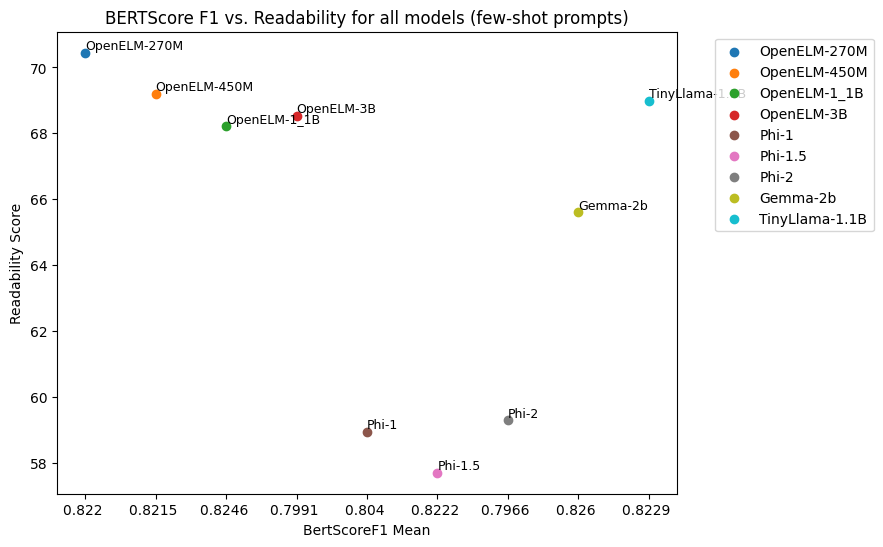

In [65]:
 # Get a colormap with enough colors
# Model names and corresponding colors for annotation
names = ["OpenELM-270M", "OpenELM-450M", "OpenELM-1_1B", "OpenELM-3B", "Phi-1", "Phi-1.5", "Phi-2", "Gemma-2b", "TinyLlama-1.1B"]
colors = plt.cm.get_cmap('tab10', len(names)).colors 

# Plotting all scores vs each score with each model as a different color
fig, ax = plt.subplots(figsize=(8, 6))

# BERTScore F1 vs. Readability
for i in range(len(scores_df)):
    ax.scatter(scores_df['BertScoreF1'][i],scores_df['Readability'][i],  color=colors[i], label=names[i])
    ax.annotate(names[i], (scores_df['BertScoreF1'][i], scores_df['Readability'][i] ), fontsize=9, ha='left', va='bottom')


# Adding legend
ax.legend()

# Adding labels and title
ax.set_xlabel('BertScoreF1 Mean')
ax.set_ylabel('Readability Score')

ax.set_title('BERTScore F1 vs. Readability for all models (few-shot prompts)')

# Place the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Display the plot
plt.show()

In [69]:
# readability score for few-shot prompts

readability_score_few_shot =  round(readability_score(few_short_prompt), 2)
print(f"Readability Score for few-shot prompts: {readability_score_few_shot}")

Readability Score for few-shot prompts: 60.27


## The remanining the experimentation/research code trying to make it more simple


In [ ]:
class MemoryAndInferenceCalculator:

  def __init__(self, model_name, finance_dict, prompt = None , ground_truth = None):
    self.model_name = model_name
    self.prompt = prompt
    self.tokenizer = None
    self.model = None
    self.prompt_reponses = []
    self.trust_remote_code=True
    self.similarity_scores_df = None
    self.ground_truth = ground_truth
    self.ground_truth_scores_df = None
    self.finance_dict = finance_dict
    self.scores = None
    self.all_prompt_metrics = None
    self.sts_score = None
    self.rouge1 = None
    self.rouge2 = None
    self.rougeL = None

  def bytes_to_mb(self,bytes):
    return bytes / (1024 * 1024)

  def bytes_to_gb(self,bytes):
    return bytes / (1024 * 1024 * 1024)

  def calculate_memory(self):
    torch.set_default_device("cuda")
    accelerator = Accelerator()
    mem_before = psutil.virtual_memory().available
    if self.model_name == "google/gemma-2b":
      self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
    else:
      self.tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
    self.tokenizer.pad_token = self.tokenizer.eos_token
    self.model = AutoModelForCausalLM.from_pretrained(self.model_name, trust_remote_code=self.trust_remote_code,)
    mem_after = psutil.virtual_memory().available
    memory_used_bytes = mem_before - mem_after
    memory_used_mb = self.bytes_to_mb(memory_used_bytes)
    memory_used_gb = self.bytes_to_gb(memory_used_bytes)
    print("----------------------------------------------------------------------------------------")
    print(f"{self.model_name} took {memory_used_bytes:.4f} bytes during loading the model \n")
    print(f"{self.model_name} took {memory_used_mb:.4f} mega bytes during loading the model \n")
    print(f"{self.model_name} took {memory_used_gb:.4f} giga bytes during loading the model \n")
    print("----------------------------------------------------------------------------------------")

    return memory_used_bytes, memory_used_mb, memory_used_gb

  def inference_time_and_memory(self):
    start_ts = time.time()
    mem_before = psutil.virtual_memory().available
    self.tokenizer.pad_token = self.tokenizer.eos_token
    inputs = self.tokenizer(self.prompt, return_tensors="pt", return_attention_mask=True, padding=True,
                              truncation=True,add_special_tokens=True, max_length = 512)
    outputs = self.model.generate(**inputs, max_new_tokens=128, top_k = 30, top_p = 0.8, do_sample = True,no_repeat_ngram_size=5,)
    text = self.tokenizer.batch_decode(outputs, skip_special_tokens = True)[0]
    prompt_length = len(self.prompt)
    text = text[prompt_length:]
    self.prompt_reponses.append(text)
    print(f"Response from Model: {text}")
    end_ts = time.time()
    mem_after = psutil.virtual_memory().available
    time_taken = round((end_ts-start_ts),4)
    print("----------------------------------------------------------------------------------------")
    print(f"Inference Time [s]: {time_taken} by {self.model_name} \n")
    memory_used_bytes = mem_before - mem_after
    memory_used_mb = self.bytes_to_mb(memory_used_bytes)
    memory_used_gb = self.bytes_to_gb(memory_used_bytes)
    print("----------------------------------------------------------------------------------------")
    print(f"{self.model_name} took {memory_used_bytes:.4f} bytes during Inference \n")
    print(f"{self.model_name} took {memory_used_mb:.4f} mega bytes during Inference \n")
    print(f"{self.model_name} took {memory_used_gb:.4f} giga bytes during Inference \n")
    print("----------------------------------------------------------------------------------------")
    return time_taken, memory_used_bytes, memory_used_mb, memory_used_gb

  def average_inference_time(self):
    self.prompt_reponses = []
    time_begin = time.time()
    self.tokenizer.pad_token = self.tokenizer.eos_token
    for i in range(10):
      inputs = self.tokenizer(self.prompt, return_tensors="pt", return_attention_mask=True, padding=True,
                              truncation=True,add_special_tokens=True, max_length = 512)
      outputs = self.model.generate(**inputs, max_new_tokens=128,  top_k = 30, top_p = 0.8, do_sample = True,no_repeat_ngram_size=5,)
      text = self.tokenizer.batch_decode(outputs, skip_special_tokens = True)[0]
      prompt_length = len(self.prompt)
      text = text[prompt_length:]
      self.prompt_reponses.append(text)
    time_end = time.time()
    avg_time = round((time_end - time_begin) / len(self.prompt_reponses),4)
    print("----------------------------------------------------------------------------------------")
    print(f"Average inference time taken by {self.model_name} is {avg_time} seconds \n")
    print("----------------------------------------------------------------------------------------")
    print(f"All responses: \n")
    for prompt in self.prompt_reponses:
      print(prompt + "\n")
      print("----------------------------------------------------------------------------------------")
    return avg_time, self.prompt_reponses

  def average_output_word_length(self):
    word_length = 0
    for i in range(len(self.prompt_reponses)):
      word_length += len(self.prompt_reponses[i])
    avg_word_length = word_length / len(self.prompt_reponses)
    print("----------------------------------------------------------------------------------------")
    print(f"Average output word length for the {self.model_name} is {avg_word_length} \n")
    return avg_word_length

  def average_output_token_length(self):
    token_length = 0
    for i in range(len(self.prompt_reponses)):
      tokens = self.tokenizer.tokenize(self.prompt_reponses[i])
      token_length += len(tokens)
      avg_token_length = token_length / len(self.prompt_reponses)
    print("----------------------------------------------------------------------------------------")
    print(f"Average output tokens length for the {self.model_name} is {avg_token_length} \n")
    return avg_token_length



  def cal_cosine_similarity(self, input1, input2):
    # Pre-trained cross encoder
    model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
    sentence_combinations = [input1, input2]
    cosine = round(model.cro(sentence_combinations),4)
    print("----------------------------------------------------------------------------------------")
    print(f"cosine similarity between given sentences is {cosine} \n")
    return cosine




  def similarity_scores(self, input1, input2):
    bertScore = bert_score.compute(predictions=[input1], references=[input2], lang='en', device = "cuda")
    rougeScore = rouge.compute(predictions=[input1], references=[input2])
    r1 = round(rougeScore['rouge1'][0][2],4)
    r2 = round(rougeScore['rouge2'][0][2],4)
    rl = round(rougeScore['rougeL'][0][2],4)
    bertScoreF1 = round(bertScore['f1'][0],4)
    print("----------------------------------------------------------------------------------------")
    print(f" f1 score for  rouge1:  {r1} \n")
    print(f" f1 score for  rouge2:  {r2} \n")
    print(f" f1 score for  rougeL:  {rl} \n")
    print(f" f1 score for  bertscore:  {bertScoreF1} \n")
    return r1, r2, rl, bertScoreF1

  def response_similarities(self):
    responses = self.prompt_reponses
    num_responses = len(responses)
    self.similarity_scores_df = pd.DataFrame()
    for i in range(num_responses):
      for j in range(i + 1, num_responses):
        response_pair = f"{i+1}-{j+1}"
        cosine_sim = self.cal_cosine_similarity(responses[i], responses[j])
        rouge_scores = self.similarity_scores(responses[i], responses[j])
        self.similarity_scores_df.loc[response_pair, 'Cosine Similarity'] = cosine_sim
        self.similarity_scores_df.loc[response_pair, 'Rouge1'] = rouge_scores[0]
        self.similarity_scores_df.loc[response_pair, 'Rouge2'] = rouge_scores[1]
        self.similarity_scores_df.loc[response_pair, 'RougeL'] = rouge_scores[2]
        self.similarity_scores_df.loc[response_pair, 'BertScore F1'] = rouge_scores[3]
        self.sts_score += cosine_sim
        self.rouge1 += rouge_scores[0]
        self.rouge2 += rouge_scores[1]
        self.rougeL += rouge_scores[2]
    self.sts_score /= num_responses
    self.rouge1 /= num_responses
    self.rouge2 /= num_responses
    self.rougeL /= num_responses
    print("----------------------------------------------------------------------------------------")
    print(f"\nMean STS score: {self.sts_score}")
    print("----------------------------------------------------------------------------------------")
    print(f"\nMean rouge1 score: {self.rouge1}")
    print("----------------------------------------------------------------------------------------")
    print(f"\nMean rouge2 score: {self.rouge2}")
    print("----------------------------------------------------------------------------------------")
    print(f"\nMean rougeL score: {self.rougeL}")
    print("----------------------------------------------------------------------------------------")
    print(f"\nSimilarity Scores:\n")
    print(self.similarity_scores_df)
    return self.similarity_scores_df

  def plot_scores(self):
    df = self.similarity_scores_df
    # @title Cosine Similarity
    plt.figure(figsize=(8, 4))
    df['Cosine Similarity'].plot(kind='line', title='Cosine Similarity between responses')
    plt.gca().spines[['top', 'right']].set_visible(False)

    # @title Rouge1
    plt.figure(figsize=(8, 4))
    df['Rouge1'].plot(kind='line', title='Rouge1 between responses')
    plt.gca().spines[['top', 'right']].set_visible(False)

    # @title Rouge2
    plt.figure(figsize=(8, 4))
    df['Rouge2'].plot(kind='line',  title='Rouge2 between responses')
    plt.gca().spines[['top', 'right']].set_visible(False)

    # @title RougeL
    plt.figure(figsize=(8, 4))
    df['RougeL'].plot(kind='line',  title='RougeL between responses')
    plt.gca().spines[['top', 'right']].set_visible(False)

    # @title BertScore F1
    plt.figure(figsize=(8, 4))
    df['BertScore F1'].plot(kind='line',  title='BertScore F1 between responses')
    plt.gca().spines[['top', 'right']].set_visible(False)

    plt.show()

  def ground_truth_similarity(self):
    responses = self.prompt_reponses
    num_responses = len(responses)
    ground_truth_scores_df = pd.DataFrame()
    for i in range(num_responses):
        cosine_sim = self.cal_cosine_similarity(self.ground_truth, responses[i])
        rouge_scores = self.similarity_scores(self.ground_truth, responses[i])
        response_index = f"Response-{i+1}"
        ground_truth_scores_df.loc[response_index, 'Cosine Similarity'] = cosine_sim
        ground_truth_scores_df.loc[response_index, 'Rouge1'] = rouge_scores[0]
        ground_truth_scores_df.loc[response_index, 'Rouge2'] = rouge_scores[1]
        ground_truth_scores_df.loc[response_index, 'RougeL'] = rouge_scores[2]
        ground_truth_scores_df.loc[response_index, 'BertScore F1'] = rouge_scores[3]

    print("----------------------------------------------------------------------------------------")
    print(f"\nSimilarity Scores with Ground Truth:\n")
    print(ground_truth_scores_df)
    self.ground_truth_scores_df = ground_truth_scores_df
    return ground_truth_scores_df

  def plot_ground_truth_scores(self):
    df = self.ground_truth_scores_df

    plt.figure(figsize=(8, 4))
    df['Cosine Similarity'].plot(kind='line', title='Cosine Similarity with Ground Truth')
    plt.gca().spines[['top', 'right']].set_visible(False)

    plt.figure(figsize=(8, 4))
    df['Rouge1'].plot(kind='line', title='Rouge1 with Ground Truth')
    plt.gca().spines[['top', 'right']].set_visible(False)

    plt.figure(figsize=(8, 4))
    df['Rouge2'].plot(kind='line', title='Rouge2 with Ground Truth')
    plt.gca().spines[['top', 'right']].set_visible(False)

    plt.figure(figsize=(8, 4))
    df['RougeL'].plot(kind='line', title='RougeL with Ground Truth')
    plt.gca().spines[['top', 'right']].set_visible(False)

    plt.figure(figsize=(8, 4))
    df['BertScore F1'].plot(kind='line', title='BertScore F1 with Ground Truth')
    plt.gca().spines[['top', 'right']].set_visible(False)

    plt.show()


  def plot_all_scores(self):
    df = self.scores

    plt.figure(figsize=(8, 4))
    df['Cosine Similarity'].plot(kind='line', title='Cosine Similarity between all respones for various questions')
    plt.gca().spines[['top', 'right']].set_visible(False)

    plt.figure(figsize=(8, 4))
    df['Rouge1'].plot(kind='line', title='Rouge1 between all respones for various questions')
    plt.gca().spines[['top', 'right']].set_visible(False)

    plt.figure(figsize=(8, 4))
    df['Rouge2'].plot(kind='line', title='Rouge2 between all respones for various questions')
    plt.gca().spines[['top', 'right']].set_visible(False)

    plt.figure(figsize=(8, 4))
    df['RougeL'].plot(kind='line', title='RougeL between all respones for various questions')
    plt.gca().spines[['top', 'right']].set_visible(False)

    plt.figure(figsize=(8, 4))
    df['BertScore F1'].plot(kind='line', title='BertScore between all respones for various questions')
    plt.gca().spines[['top', 'right']].set_visible(False)

    plt.show()

  def all_question_scores(self):
    finance_dict = self.finance_dict
    average_output_word_length = 0
    average_output_token_length = 0
    all_sts_score = []
    all_rouge1 = []
    all_rouge2 = []
    all_rougeL = []
    all_bertscore = []
    scores = pd.DataFrame()
    for i, (prompt, ground_truth) in enumerate(self.finance_dict.items(), start = 1):
      self.tokenizer.pad_token = self.tokenizer.eos_token
      inputs = self.tokenizer(prompt, return_tensors="pt", return_attention_mask=True, padding=True,
                                truncation=True,add_special_tokens=True, max_length = 512)
      outputs = self.model.generate(**inputs,max_new_tokens=128, top_k = 30, top_p = 0.8, do_sample = True,no_repeat_ngram_size=5,)
      text = self.tokenizer.batch_decode(outputs, skip_special_tokens = True)[0]
      prompt_length = len(prompt)
      text = text[prompt_length:]
      average_output_word_length += len(text)
      average_output_token_length += len(self.tokenizer.tokenize(text))
      cosine_sim = self.cal_cosine_similarity(ground_truth, text)
      rouge_scores = self.similarity_scores(ground_truth, text)
      response_index = f"{i}"
      scores.loc[response_index, 'Cosine Similarity'] = cosine_sim
      scores.loc[response_index, 'Rouge1'] = rouge_scores[0]
      scores.loc[response_index, 'Rouge2'] = rouge_scores[1]
      scores.loc[response_index, 'RougeL'] = rouge_scores[2]
      scores.loc[response_index, 'BertScore F1'] = rouge_scores[3]
      all_sts_score.append(cosine_sim)
      all_rouge1.append(rouge_scores[0])
      all_rouge2.append(rouge_scores[1])
      all_rougeL.append(rouge_scores[2])
      all_bertscore.append(rouge_scores[3])
    self.scores = scores
    num_questions = len(self.finance_dict)
    average_output_word_length /= num_questions
    average_output_token_length /= num_questions
    all_sts_score = np.mean(all_sts_score)
    all_rouge1 = np.mean(all_rouge1)
    all_rouge2 = np.mean(all_rouge2)
    all_rougeL = np.mean(all_rougeL)
    all_bertscore = np.mean(all_bertscore)
    print("----------------------------------------------------------------------------------------")
    print(f"\nAverage output word length for all questions is {average_output_word_length}")
    print(f"\nAverage output token length for all questions is {average_output_token_length}")
    print(f"\nMean STS score for all questions: {all_sts_score}")
    print(f"\nMean Rouge1 score for all questions: {all_rouge1}")
    print(f"\nMean Rouge2 score for all questions: {all_rouge2}")
    print(f"\nMean RougeL score for all questions: {all_rougeL}")
    print(f"\nMean Bertscore score for all questions: {all_bertscore}")
    print("----------------------------------------------------------------------------------------")
    print(f"\nSimilarity Scores for all questions:\n")
    print(scores)
    return scores


  def all_results_plots(self):
    calculator = MemoryAndInferenceCalculator(self.model_name,  self.finance_dict)
    time_taken, memory_used_bytes, memory_used_mb, memory_used_gb = 0,0,0,0
    average_inference_time = 0
    average_output_word_length = 0
    average_output_token_length = 0
    all_prompt_metrics = {}
    i = 1
    for prompt, ground_truth in self.finance_dict.items():
      calculator.prompt = prompt
      calculator.ground_truth = ground_truth
      if i == 1:
        calculator.calculate_memory()
      time_taken_single, memory_used_bytes_single, memory_used_mb_single, memory_used_gb_single = calculator.inference_time_and_memory()
      time_taken += time_taken_single
      memory_used_bytes += memory_used_bytes_single
      memory_used_mb += memory_used_mb_single
      memory_used_gb += memory_used_gb_single
      time_taken_for_prompt, prompt_responses = calculator.average_inference_time()
      average_inference_time += time_taken_for_prompt
      output_word_length = calculator.average_output_word_length()
      average_output_word_length += output_word_length
      output_token_length = calculator.average_output_token_length()
      average_output_token_length += output_token_length
      all_prompt_metrics[prompt] = {
        'inference_time_taken': time_taken_single,
        'memory_used_in_bytes': memory_used_bytes_single,
        'memory_used_in_megabytes': memory_used_mb_single,
        'memory_used_in_gigabytes' : memory_used_gb_single,
        'average_inference_time_10_reponses': time_taken_for_prompt,
        'all_10_responses' : prompt_responses,
        'avg_word_length_10_responses' : output_word_length,
        'avg_token_length_10_responses' : output_token_length
    }
      calculator.response_similarities()
      calculator.plot_scores()
      calculator.ground_truth_similarity()
      calculator.plot_ground_truth_scores()
      if i == 1:
        calculator.all_question_scores()
        calculator.plot_all_scores()
      i = 0
      print("--------------------------------------------------------------------")
      print(f"Prompt Metrics for {prompt}: {all_prompt_metrics[prompt]}")
    self.all_prompt_metrics = all_prompt_metrics
    num_questions = len(self.finance_dict)
    average_time_taken_for_single_response = time_taken / num_questions
    memory_used_bytes /= num_questions
    memory_used_mb /= num_questions
    memory_used_gb /= num_questions
    average_inference_time /= num_questions
    average_output_word_length /= num_questions
    average_output_token_length /= num_questions
    print(f"-----------------------------------------------------------------------------------------------")
    print(f"\nTotal averages: \n")
    print(f"\n Average time taken for single response: {average_time_taken_for_single_response} seconds\n")
    print(f"\n Average memory used:  {memory_used_bytes} bytes\n")
    print(f"\n Average memory used: {memory_used_mb} megabytes\n")
    print(f"\n Average memory used: {memory_used_gb} gigabytes\n")
    print(f"\n Average inference time for 10 responses: {average_inference_time} seconds\n")
    print(f"\n Average all outputs word length {average_output_word_length} \n")
    print(f"\n Average all outputs token length {average_output_token_length} \n")
    return all_prompt_metrics


In [ ]:
def similarity_scores( input1, input2):
  bertScore = bert_score.compute(predictions=[input1], references=[input2], lang='en', device = "cuda")
  rougeScore = rouge.compute(predictions=[input1], references=[input2])
  r1 = round(rougeScore['rouge1'][0][2],4)
  r2 = round(rougeScore['rouge2'][0][2],4)
  rl = round(rougeScore['rougeL'][0][2],4)
  bertScoreF1 = round(bertScore['f1'][0],4)
  # print("----------------------------------------------------------------------------------------")
  # print(f" f1 score for  rouge1:  {r1} \n")
  # print(f" f1 score for  rouge2:  {r2} \n")
  # print(f" f1 score for  rougeL:  {rl} \n")
  # print(f" f1 score for  bertscore:  {bertScoreF1} \n")
  return r1, r2, rl, bertScoreF1

In [ ]:
def cal_cosine_similarity( input1, input2):
  # Pre-trained cross encoder
  model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")
  if not isinstance(input1, str) or not isinstance(input2, str):
        return 0
  sentence_combinations = [input1, input2]
  cosine = round(model.predict(sentence_combinations),4)
  # print("----------------------------------------------------------------------------------------")
  # print(f"cosine similarity between given sentences is {cosine} \n")
  return cosine

In [ ]:
def all_question_scores(finance_dict, model_name):
  finance_dict = finance_dict
  average_output_word_length = 0
  average_output_token_length = 0
  all_sts_score = []
  all_rouge1 = []
  all_rouge2 = []
  all_rougeL = []
  all_bertscore = []
  scores = pd.DataFrame()

  if model_name == "google/gemma-2b":
      tokenizer = AutoTokenizer.from_pretrained(model_name)
  else:
      tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

  if model_name in model_with_3_billon:
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, torch_dtype=torch.bfloat16)
  else:
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
  tokenizer.pad_token = tokenizer.eos_token
  for i, (prompt, ground_truth) in enumerate(finance_dict.items(), start = 1):
    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True, padding=True,
                              truncation=True,add_special_tokens=True, max_length = 512)
    outputs = model.generate(**inputs,max_new_tokens=128, top_k = 30, top_p = 0.8, do_sample = True,no_repeat_ngram_size=5,)
    text = tokenizer.batch_decode(outputs, skip_special_tokens = True)[0]
    prompt_length = len(prompt)
    text = text[prompt_length:]
    average_output_word_length += len(text)
    average_output_token_length += len(tokenizer.tokenize(text))
    cosine_sim = cal_cosine_similarity(ground_truth, text)
    rouge_scores = similarity_scores(ground_truth, text)
    response_index = f"{i}"
    scores.loc[response_index, 'STS Similarity'] = cosine_sim
    scores.loc[response_index, 'Rouge1'] = rouge_scores[0]
    scores.loc[response_index, 'Rouge2'] = rouge_scores[1]
    scores.loc[response_index, 'RougeL'] = rouge_scores[2]
    scores.loc[response_index, 'BertScore F1'] = rouge_scores[3]
    all_sts_score.append(cosine_sim)
    all_rouge1.append(rouge_scores[0])
    all_rouge2.append(rouge_scores[1])
    all_rougeL.append(rouge_scores[2])
    all_bertscore.append(rouge_scores[3])
  num_questions = len(finance_dict)
  average_output_word_length /= num_questions
  average_output_token_length /= num_questions
  all_sts_score = np.mean(all_sts_score)
  all_rouge1 = np.mean(all_rouge1)
  all_rouge2 = np.mean(all_rouge2)
  all_rougeL = np.mean(all_rougeL)
  all_bertscore = np.mean(all_bertscore)
  print("----------------------------------------------------------------------------------------")
  print(f"\nAverage output word length for all questions is {average_output_word_length}")
  print(f"\nAverage output token length for all questions is {average_output_token_length}")
  print(f"\nMean STS score for all questions: {all_sts_score}")
  print(f"\nMean Rouge1 score for all questions: {all_rouge1}")
  print(f"\nMean Rouge2 score for all questions: {all_rouge2}")
  print(f"\nMean RougeL score for all questions: {all_rougeL}")
  print(f"\nMean Bertscore score for all questions: {all_bertscore}")
  print("----------------------------------------------------------------------------------------")
  print(f"\nSimilarity Scores for all questions:\n")
  print(scores)
  return scores

In [ ]:
scores_df = all_question_scores(finance_dict, "apple/OpenELM-270M")

In [ ]:
def plot_ground_truth_scores(scores_df):
  df = scores_df

  plt.figure(figsize=(8, 4))
  df['STS Similarity'].plot(kind='line', title='STS Similarity with Ground Truth')
  plt.gca().spines[['top', 'right']].set_visible(False)

  plt.figure(figsize=(8, 4))
  df['Rouge1'].plot(kind='line', title='Rouge1 with Ground Truth')
  plt.gca().spines[['top', 'right']].set_visible(False)

  plt.figure(figsize=(8, 4))
  df['Rouge2'].plot(kind='line', title='Rouge2 with Ground Truth')
  plt.gca().spines[['top', 'right']].set_visible(False)

  plt.figure(figsize=(8, 4))
  df['RougeL'].plot(kind='line', title='RougeL with Ground Truth')
  plt.gca().spines[['top', 'right']].set_visible(False)

  plt.figure(figsize=(8, 4))
  df['BertScore F1'].plot(kind='line', title='BertScore F1 with Ground Truth')
  plt.gca().spines[['top', 'right']].set_visible(False)

  plt.show()

In [ ]:
plot_ground_truth_scores(scores_df)

In [ ]:
# !pip install accelerate
# !pip install datasets
# !pip install bert_score
# !pip install rouge_score
# !pip install flash_attn
# !pip install sentence_transformers
# # import nltk
# # nltk.download('punkt')
# # nltk.download('stopwords')

In [ ]:
def average_inference_time(finance_dict, model_name):
  if model_name == "google/gemma-2b":
      tokenizer = AutoTokenizer.from_pretrained(model_name)
  else:
      tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

  if model_name in model_with_3_billon:
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, torch_dtype=torch.bfloat16)
  else:
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)

  tokenizer.pad_token = tokenizer.eos_token
  time_begin = time.time()
  for i, (prompt, ground_truth) in enumerate(finance_dict.items(), start = 1):
    inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True, padding=True,
                              truncation=True,add_special_tokens=True, max_length = 512)
    outputs = model.generate(**inputs,max_new_tokens=128, top_k = 30, top_p = 0.8, do_sample = True,no_repeat_ngram_size=5,)
    text = tokenizer.batch_decode(outputs, skip_special_tokens = True)[0]
  time_end = time.time()
  avg_time = round((time_end - time_begin) / len(finance_dict),4)
  print("----------------------------------------------------------------------------------------")
  print(f"Average inference time taken by {model_name} is {avg_time} seconds \n")
  print("----------------------------------------------------------------------------------------")
  # print(f"All responses: \n")
  # for prompt in prompt_reponses:
  #   print(prompt + "\n")
  #   print("----------------------------------------------------------------------------------------")
  return avg_time, prompt_reponses

In [ ]:
# @title


# Memory calculation load the model ten times, delete run timea and select new run time  everytime when loading the model

def bytes_to_mb(bytes):
  return bytes / (1024 * 1024)

def bytes_to_gb(bytes):
  return bytes / (1024 * 1024 * 1024)

def calculate_memory(model_name):
  torch.set_default_device("cuda")
  # accelerator = Accelerator()
  mem_before = psutil.virtual_memory().available
  if model_name == "google/gemma-2b":
    tokenizer = AutoTokenizer.from_pretrained(model_name)
  else:
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
  tokenizer.pad_token = tokenizer.eos_token
  model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
  mem_after = psutil.virtual_memory().available
  memory_used_bytes = mem_before - mem_after
  memory_used_mb = bytes_to_mb(memory_used_bytes)
  memory_used_gb = bytes_to_gb(memory_used_bytes)
  print("----------------------------------------------------------------------------------------")
  # print(f"{model_name} took {memory_used_bytes:.4f} bytes during loading the model \n")
  print(f"{model_name} took {memory_used_mb:.4f} mega bytes during loading the model \n")
  # print(f"{model_name} took {memory_used_gb:.4f} giga bytes during loading the model \n")
  print("----------------------------------------------------------------------------------------")

  return  memory_used_mb

memory_used = [710.92578125,
 885.41796875,
 716.56640625,
 745.13671875,
 722.796875,
 749.76953125,
 616.44140625]


# add the memory after getting the result
memory = calculate_memory("microsoft/phi-1_5")
memory_used.append(memory)
final_memory = round(np.mean(memory_used),4)
final_memory

In [ ]:
avg_time, all_question_prompt_reponses = average_inference_time(finance_dict, "apple/OpenELM-270M")

In [ ]:
def consistent_check(finance_dict, model_name):
  prompt_reponses = []
  if model_name == "google/gemma-2b":
      tokenizer = AutoTokenizer.from_pretrained(model_name)
  else:
      tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

  if model_name in model_with_3_billon:
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, torch_dtype=torch.bfloat16)
  else:
    model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True)
  tokenizer.pad_token = tokenizer.eos_token
  for i, (prompt, ground_truth) in enumerate(finance_dict.items(), start = 1):
    for i in range(10):
      inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True, padding=True,
                              truncation=True,add_special_tokens=True, max_length = 512)
      outputs = model.generate(**inputs, max_new_tokens=128,  top_k = 30, top_p = 0.8, do_sample = True,no_repeat_ngram_size=5,)
      text = tokenizer.batch_decode(outputs, skip_special_tokens = True)[0]
      prompt_length = len(prompt)
      text = text[prompt_length:]
      prompt_reponses.append(text)
  return prompt_reponses

In [ ]:
consistent_prompt_reponses = consistent_check(finance_dict, "apple/OpenELM-270M")

In [ ]:
def response_similarities(prompt_reponses):
  responses = prompt_reponses
  num_responses = len(responses)
  similarity_scores_df = pd.DataFrame()
  for i in range(num_responses):
    for j in range(i + 1, num_responses):
      response_pair = f"{i+1}-{j+1}"
      cosine_sim = cal_cosine_similarity(responses[i], responses[j])
      rouge_scores = similarity_scores(responses[i], responses[j])
      similarity_scores_df.loc[response_pair, 'STS Similarity'] = cosine_sim
      similarity_scores_df.loc[response_pair, 'Rouge1'] = rouge_scores[0]
      similarity_scores_df.loc[response_pair, 'Rouge2'] = rouge_scores[1]
      similarity_scores_df.loc[response_pair, 'RougeL'] = rouge_scores[2]
      similarity_scores_df.loc[response_pair, 'BertScore F1'] = rouge_scores[3]
      sts_score += cosine_sim
      rouge1 += rouge_scores[0]
      rouge2 += rouge_scores[1]
      rougeL += rouge_scores[2]
  sts_score /= num_responses
  rouge1 /= num_responses
  rouge2 /= num_responses
  rougeL /= num_responses
  print("----------------------------------------------------------------------------------------")
  print(f"\nMean STS score: {sts_score}")
  print("----------------------------------------------------------------------------------------")
  print(f"\nMean rouge1 score: {rouge1}")
  print("----------------------------------------------------------------------------------------")
  print(f"\nMean rouge2 score: {rouge2}")
  print("----------------------------------------------------------------------------------------")
  print(f"\nMean rougeL score: {rougeL}")
  print("----------------------------------------------------------------------------------------")
  print(f"\nSimilarity Scores:\n")
  print(similarity_scores_df)
  return similarity_scores_df

def plot_scores(similarity_scores_df):
  df = similarity_scores_df
  # @title Cosine Similarity
  plt.figure(figsize=(8, 4))
  df['STS Similarity'].plot(kind='line', title='Cosine Similarity between responses')
  plt.gca().spines[['top', 'right']].set_visible(False)

  # @title Rouge1
  plt.figure(figsize=(8, 4))
  df['Rouge1'].plot(kind='line', title='Rouge1 between responses')
  plt.gca().spines[['top', 'right']].set_visible(False)

  # @title Rouge2
  plt.figure(figsize=(8, 4))
  df['Rouge2'].plot(kind='line',  title='Rouge2 between responses')
  plt.gca().spines[['top', 'right']].set_visible(False)

  # @title RougeL
  plt.figure(figsize=(8, 4))
  df['RougeL'].plot(kind='line',  title='RougeL between responses')
  plt.gca().spines[['top', 'right']].set_visible(False)

  # @title BertScore F1
  plt.figure(figsize=(8, 4))
  df['BertScore F1'].plot(kind='line',  title='BertScore F1 between responses')
  plt.gca().spines[['top', 'right']].set_visible(False)

  plt.show()


In [ ]:
similarity_scores_df = response_similarities(consistent_prompt_reponses)
plot_scores(similarity_scores_df)

In [ ]:
# import psutil
# import time
# import os
# import accelerate
# from accelerate import Accelerator
# import torch
# from transformers import AutoTokenizer, AutoModelForCausalLM
# from sentence_transformers import SentenceTransformer, util
# from sentence_transformers.cross_encoder import CrossEncoder
# from transformers import StoppingCriteria
# from transformers import BertModel, BertTokenizer
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from datasets import load_metric
# from scipy import stats
# import pandas as pd
# import os
# import re
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline
# bert_score = load_metric('bertscore', trust_remote_code=True)
# rouge = load_metric('rouge', trust_remote_code=True)


In [ ]:
# xl_file = pd.ExcelFile("FinGPT_finance_dataset.xlsx")

# dfs = {sheet_name: xl_file.parse(sheet_name)
#           for sheet_name in xl_file.sheet_names}
# dataset =  dfs['Selected Questions']
# dataset =  dfs['Selected Questions']
# dataset.drop("Unnamed: 0", inplace = True, axis = 1)
# dataset_no_duplicates = dataset.drop_duplicates(subset=['input']).reset_index(drop = True)
# dataset_no_duplicates['total_input'] = dataset_no_duplicates['instruction'] + "\n" + dataset_no_duplicates['input']
# new_dataset = dataset_no_duplicates.drop(['input', 'instruction'], axis = 1)
# new_dataset = new_dataset[['total_input', 'output']]
# import pandas as pd
# from  transformers import AutoTokenizer, AutoModelForCausalLM

# new_dataset = pd.read_csv("train_file.csv")
# new_dataset = new_dataset.sample(n = 100, random_state = 7)
# Questions = new_dataset.set_index('total_input')
# finance_dict = Questions['output'].to_dict()
# finance_dict

In [ ]:
test = MemoryAndInferenceCalculator("apple/OpenELM-270M", finance_dict)

In [ ]:
test.all_results_plots()

In [ ]:
# import pandas as pd
# xl_file = pd.ExcelFile("FinGPT_finance_dataset.xlsx")

# dfs = {sheet_name: xl_file.parse(sheet_name)
#           for sheet_name in xl_file.sheet_names}
# dataset =  dfs['Selected Questions']

In [ ]:
dataset =  dfs['Selected Questions']
dataset.drop("Unnamed: 0", inplace = True, axis = 1)
dataset

In [ ]:
# xl_file = pd.ExcelFile("FinGPT_finance_dataset.xlsx")

# dfs = {sheet_name: xl_file.parse(sheet_name)
#           for sheet_name in xl_file.sheet_names}
# dataset =  dfs['Selected Questions']
# dataset =  dfs['Selected Questions']
# dataset.drop("Unnamed: 0", inplace = True, axis = 1)
# dataset_no_duplicates = dataset.drop_duplicates(subset=['input']).reset_index(drop = True)
# dataset_no_duplicates['total_input'] = dataset_no_duplicates['instruction'] + "\n" + dataset_no_duplicates['input']
# new_dataset = dataset_no_duplicates.drop(['input', 'instruction'], axis = 1)
# new_dataset = new_dataset[['total_input', 'output']]

In [ ]:
dataset['output'][1]

In [ ]:
dataset_no_duplicates = dataset.drop_duplicates(subset=['input']).reset_index(drop = True)
dataset_no_duplicates

In [ ]:
dataset_no_duplicates['total_input'] = dataset_no_duplicates['instruction'] + "\n" + dataset_no_duplicates['input']
dataset_no_duplicates

In [ ]:
new_dataset = dataset_no_duplicates.drop(['input', 'instruction'], axis = 1)
new_dataset = new_dataset[['total_input', 'output']]
new_dataset

In [ ]:
Questions = new_dataset.set_index('total_input')
finance_dict = Questions['output'].to_dict()
finance_dict

In [ ]:
for i, (key,value) in enumerate(finance_dict.items()):
  print(f"{key} : {value}")
  if i == 10:
    break

In [ ]:
!pip install accelerate
import accelerate

In [ ]:
for model in model_name:
  print(accelerate estimate-memory model)

In [ ]:
accelerate estimate-memory bert-base-cased

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import csv

# file_path = "/content/drive/MyDrive/finance_dict.csv"

# with open(file_path, 'w', newline='') as csv_file:
#   writer = csv.writer(csv_file)
#   for key, value in finance_dict.items():
#     writer.writerow([key, value])


In [ ]:
  # def cal_cosine_similarity(self, input1, input2):
  #   tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
  #   model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states=True).eval()
  #   inputs1 = tokenizer(input1, return_tensors='pt',)
  #   inputs2 = tokenizer(input2, return_tensors='pt',)
  #   with torch.no_grad():
  #       output1 = model(**inputs1)
  #       output2 = model(**inputs2)
  #       embeddings1 = output1.last_hidden_state[:,0,:].squeeze()
  #       embeddings2 = output2.last_hidden_state[:,0,:].squeeze()
  #       cosine_similarity = torch.nn.CosineSimilarity(dim=0)
  #       cosine = round(cosine_similarity(embeddings1, embeddings2).item(), 4)
  #       print("----------------------------------------------------------------------------------------")
  #       print(f"cosine similarity between given sentences is {cosine} \n")
  #       return cosine

In [ ]:
# !pip install sentence_transformers
from sentence_transformers.cross_encoder import CrossEncoder

def cal_cosine_similarity( input1, input2):
  # Pre-trained cross encoder
  model = CrossEncoder("cross-encoder/stsb-distilroberta-base")
  sentence_combinations = [input1, input2]
  cosine = round(model.predict(sentence_combinations),4)
  print("----------------------------------------------------------------------------------------")
  print(f"cosine similarity between given sentences is {cosine} \n")
  return cosine
cal_cosine_similarity("""Deposit $3,500 each month in a brokerage account and invest that money across a handful of diversified index funds. Rebalance those investments every quarter. The hard part is coming up with $3,500 each month; this is where your budget comes in.""",
    """The answer to your question is Forex trading.  You can get to 250K quicker than any other "investment" scheme.  You\'ll just need to start with at least 500K.
    """ )

In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")

# Two lists of sentences
sentences1 = [
    "The cat sits outside",
    "A man is playing guitar",
    "The new movie is awesome",
    """Fiduciary They are obligated by the rules of the exchanges they are listed with.
     Furthermore, there is a strong chance that people running the company also have stock,
     so it personally benefits them to create higher prices. Finally, maybe they don't care
     about the prices directly, but by being a good company with a good product or service,
     they are desirable and that is expressed as a higher stock price.
    Not every action is because it will raise the stock price,
    but because it is good for business which happens to make the stock more valuable.""",
    """I like to play basketball. I am the college basketball captain. I play point guard position.
    I have won many games. I have good handles.
    """
]

sentences2 = [
    "The dog plays in the garden",
    "A woman watches TV",
    "  movie is awesome",
    """
     A fiduciary is bound by the regulations of the exchanges they are listed with. Additionally,
     it is highly likely that the individuals managing the company also own stock,
      so they have a personal interest in driving up prices.
      Furthermore, it's possible that they are not directly focused on stock prices,
       but rather on being a reputable company with quality products or services,
       which leads to a higher stock price. Not every decision is made solely to increase stock prices,
       but rather to benefit the overall business, which incidentally results in a more valuable stock.
    ""","""
    Also VW has more brands, i.e. is more diversified This isn't necessarily a good thing for investing.
      It makes the company less likely to go down, but it limits your portfolio.
      For example, say you think that Hyundai is a good alternative to Volkswagen (VW) but really like Audi.
        If you buy VW, you get some Audi but a lot more of the rest of VW.
        Then if you bought Hyundai, you'd be overrepresented in that segment of the market.
         Audi may not be structured uniquely, but it is still the only company selling Audi brand cars.
          Perhaps someone thinks that those models will do well.
          That person may think that Audi will do exceptionally well in its niche.
             Having many brands isn't necessarily great.
             General Motors had something like sixteen brands before declaring bankruptcy.
              It only has twelve now.   Now, it sounds like you feel the opposite about it.
               You don't particularly like Audi as a stock and like VW better.
    Your reasons sound perfectly reasonable (I know little about either company).
    It may even be that VW is the only one buying Audi stock, because everyone else has the same view as you.
    """
]

# Compute embedding for both lists
embeddings1 = model.encode(sentences1, convert_to_tensor=True)
embeddings2 = model.encode(sentences2, convert_to_tensor=True)

# Compute cosine-similarities
cosine_scores = util.cos_sim(embeddings1, embeddings2)

# Output the pairs with their score
for i in range(len(sentences1)):
    print("{} \t\t {} \t\t Score: {:.4f}".format(
        sentences1[i], sentences2[i], cosine_scores[i][i]
    ))

In [ ]:
!pip install sentence_transformers

In [ ]:
"""
This example computes the score between a query and all possible
sentences in a corpus using a Cross-Encoder for semantic textual similarity (STS).
It output then the most similar sentences for the given query.
"""

from sentence_transformers.cross_encoder import CrossEncoder
import numpy as np

# Pre-trained cross encoder
model = CrossEncoder("cross-encoder/stsb-distilroberta-base")

# We want to compute the similarity between the query sentence
query = "A man is eating pasta."

# With all sentences in the corpus
corpus = [
    "A man is eating food.",
    "A man is eating a piece of bread.",
    "The girl is carrying a baby.",
    "A man is riding a horse.",
    "A woman is playing violin.",
    "Two men pushed carts through the woods.",
    "A man is riding a white horse on an enclosed ground.",
    "A monkey is playing drums.",
    "A cheetah is running behind its prey.",
]

# 1. We rank all sentences in the corpus for the query
ranks = model.rank(query, corpus)

# Print the scores
print("Query:", query)
for rank in ranks:
    print(f"{rank['score']:.2f}\t{corpus[rank['corpus_id']]}")

# 2. Alternatively, you can also manually compute the score between two sentences
sentence_combinations = [[query, sentence] for sentence in corpus]
scores = model.predict(sentence_combinations)

# Sort the scores in decreasing order to get the corpus indices
ranked_indices = np.argsort(scores)[::-1]
print("scores:", scores)
print("indices:", ranked_indices)

In [ ]:
# do the average word length nd token length in all scores function and memory too

In [ ]:
# import torch
# from transformers import BertTokenizer, BertModel
# def cal_cosine_similarity( input1, input2):
#     tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#     model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states=True).eval()
#     inputs1 = tokenizer(input1, return_tensors='pt',)
#     inputs2 = tokenizer(input2, return_tensors='pt',)
#     with torch.no_grad():
#         output1 = model(**inputs1)
#         output2 = model(**inputs2)
#         embeddings1 = output1.last_hidden_state[:,0,:].squeeze()
#         embeddings2 = output2.last_hidden_state[:,0,:].squeeze()
#         cosine_similarity = torch.nn.CosineSimilarity(dim=0)
#         cosine = round(cosine_similarity(embeddings1, embeddings2).item(), 4)
#         print("----------------------------------------------------------------------------------------")
#         print(f"par wise cosine similarity between given sentences is {cosine} \n")
#         return cosine

# cal_cosine_similarity("you love playing basketball  ", " college is a place where students learn about technology")

In [ ]:


# X = input1.lower()
# Y = input2.lower()
# X_list = word_tokenize(X)
# Y_list = word_tokenize(Y)
# sw = stopwords.words('english')
# l1 =[];l2 =[]
# X_set = {w for w in X_list if not w in sw}
# Y_set = {w for w in Y_list if not w in sw}
# rvector = X_set.union(Y_set)
# for w in rvector:
#   if w in X_set: l1.append(1)
#   else: l1.append(0)
#   if w in Y_set: l2.append(1)
#   else: l2.append(0)
# cosine = round(cosine_similarity(np.array(l1).reshape(1,-1),np.array(l2).reshape(1,-1))[0][0], 4)

In [ ]:
# finance_dict = {
#     "What Is Annual Percentage Rate (APR)?":"""Annual percentage rate (APR) refers to the yearly interest generated by a sum that's charged to borrowers or paid to investors.
#      """,

#     "What Is a Business Model?":"""
#      The term business model refers to a company's plan for making a profit.
#     """,

#     "What Is Compound Interest? ":"""
#     Compound interest is interest that applies not only to the initial principal of an investment or a loan, but also to the accumulated interest from previous periods.
#     """,

#     "What Is a Dividend? " :"""
#     A dividend is the distribution of a company's earnings to its shareholders and is determined by the company's board of directors.
#     """,

#     "What Is Equity? ":"""
#     Equity represents the value that would be returned to a company’s shareholders if all of the assets were liquidated and all of the company's debts were paid off.
#     """,

#     " What Is the Goods and Services Tax (GST)? ":"""
#           The goods and services tax (GST) is a tax on goods and services sold domestically for consumption.
#     """,

#      "What Is a Hedge Fund? ":"""
#         Hedge funds are actively managed funds focused on alternative investments that commonly use risky investment strategies.
#     """,

#      "What Is an IPO? ":"""
#         An initial public offering (IPO) refers to the process of offering shares of a private corporation to the public in a new stock issuance.
#     """,

#      "What Is Liquidity? ":"""
#     Liquidity refers to the ease with which an asset, or security, can be converted into ready cash without affecting its market price.
#     """,

#      "What Is a Mutual Fund? ":"""
#         A mutual fund is a portfolio of stocks, bonds, or other securities purchased with the pooled capital of investors.
#     """,


# }

In [ ]:
# calculator = MemoryAndInferenceCalculator("TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T", "What Is the Goods and Services Tax (GST)?", "The goods and services tax (GST) is a tax on goods and services sold domestically for consumption.")
# calculator.calculate_memory()
# calculator.inference_time_and_memory()
# calculator.average_inference_time()
# calculator.average_output_word_length()
# calculator.average_output_token_length()
# calculator.response_similarities()
# calculator.plot_scores()
# calculator.ground_truth_similarity()
# calculator.plot_ground_truth_scores()

In [ ]:
# !nvidia-smi

In [ ]:
# Phi2, X Gen, Alpaca 7B Zephyr
# https://www.philschmid.de/fine-tune-llms-in-2024-with-trl
# TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T

In [ ]:
# import time



# #Predict the response for test dataset. I want to measure the speed of this prediction here.
# prompt = "What risks are involved when trading put and call options as compared to purchasing a common stock?"
# tokenizer.pad_token = tokenizer.eos_token
# #get the timestamp before inference in seconds
# start_ts = time.time()

# inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True, padding=True,
#                           truncation=True,add_special_tokens=True)

# outputs = model.generate(**inputs, max_length=128)
# text = tokenizer.batch_decode(outputs)[0]
# print(text)


# #get the timestamp after the inference in second
# end_ts = time.time()

# # print the time difference in between start and end timestamps in seconds
# print(f"Prediction Time [s]: {(end_ts-start_ts):.3f}")

In [ ]:
# outputs = model.generate(**inputs, max_length= len(prompt) + 600, top_p = 0.8, top_k = 30, do_sample = True)
# text = tokenizer.batch_decode(outputs)[0]
# print(text)

In [ ]:
# # Program to measure the similarity between
# # two sentences using cosine similarity.



# X = "What risks are involved when trading put and call options as compared to purchasing a common stock?"
# #X = "What is an ETF and how do the risks of purchasing an ETF compare to purchasing a common stock?" # Output should be 1 and it is

# Y = "What is an ETF and how do the risks of purchasing an ETF compare to purchasing a common stock?"



# def cal_cosine_similarity(input1, input2):

# 	X = input1.lower()
# 	Y = input2.lower()
# 	# tokenization
# 	X_list = word_tokenize(X)
# 	Y_list = word_tokenize(Y)

# 	# sw contains the list of stopwords
# 	sw = stopwords.words('english')
# 	l1 =[];l2 =[]

# 	# remove stop words from the string
# 	X_set = {w for w in X_list if not w in sw}
# 	Y_set = {w for w in Y_list if not w in sw}

# 	# form a set containing keywords of both strings
# 	rvector = X_set.union(Y_set)
# 	for w in rvector:
# 		if w in X_set: l1.append(1) # create a vector
# 		else: l1.append(0)
# 		if w in Y_set: l2.append(1)
# 		else: l2.append(0)
# 	c = 0

# 	# cosine formula
# 	for i in range(len(rvector)):
# 			c+= l1[i]*l2[i]
# 	cosine = c / float((sum(l1)*sum(l2))**0.5)
# 	return cosine

# cosine = cal_cosine_similarity(X, Y)

# print("similarity: ", cosine)


In [ ]:
# bert_score = load_metric('bertscore', trust_remote_code=True)
# rouge = load_metric('rouge', trust_remote_code=True)


# input1 = "What risks are involved when trading put and call options as compared to purchasing a common stock?"
# input2 =  "What is an ETF and how do the risks of purchasing an ETF compare to purchasing a common stock?"


# def similarity_scores(input1, input2):
#     bertScore = bert_score.compute(predictions=[input1], references=[input2], lang='en', device = "cuda")
#     rougeScore = rouge.compute(predictions=[input1], references=[input2])

#     r1 = rougeScore['rouge1'][0][2] # f1 score for rouge1
#     r2 = rougeScore['rouge2'][0][2] # f1 score for rouge2
#     rl = rougeScore['rougeL'][0][2] # f1 score for rougeL

#     bertScoreF1 = bertScore['f1'][0] # f1 score for bertscore
#     return r1, r2, rl, bertScoreF1

# r1, r2, rl, bertScoreF1 = similarity_scores(input1, input2)

# print(f" f1 score for  rouge1:  {r1:.4f}")
# print(f" f1 score for  rouge2:  {r2:.4f}")
# print(f" f1 score for  rougeL:  {rl:.4f}")
# print(f" f1 score for  bertscore:  {bertScoreF1:.4f}")

In [ ]:
# ## PHI MODEL

# torch.set_default_device("cuda")

# model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True)
# tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)


# prompt = "What is a dividend payment of a publicly traded company?"

# inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False)

# outputs = model.generate(**inputs, max_length=200)
# text = tokenizer.batch_decode(outputs)[0]
# print(text)


In [ ]:
# prompt = "What is an option trade in the stock market?"

# inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False)

# outputs = model.generate(**inputs, max_length=128)
# text = tokenizer.batch_decode(outputs)[0]
# print(text)

In [ ]:
# prompt = "What risks are involved when trading put and call options as compared to purchasing a common stock?"

# inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=False)

# outputs = model.generate(**inputs, max_length=128)
# text = tokenizer.batch_decode(outputs)[0]
# print(text)

In [ ]:
# tokenizer.pad_token = tokenizer.eos_token

# prompt = "What risks are involved when trading put and call options as compared to purchasing a common stock?"

# inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True, padding=True,
#                           truncation=True,add_special_tokens=True)

# outputs = model.generate(**inputs, max_length=128)
# text = tokenizer.batch_decode(outputs)[0]
# print(text)

In [ ]:

# model_name = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M", trust_remote_code=True)
# model_name = AutoModelForCausalLM.from_pretrained("apple/OpenELM-450M", trust_remote_code=True)
# model_name = AutoModelForCausalLM.from_pretrained("apple/OpenELM-1_1B", trust_remote_code=True)
# model_name = AutoModelForCausalLM.from_pretrained("apple/OpenELM-3B", trust_remote_code=True)
# model_name = AutoModelForCausalLM.from_pretrained("apple/OpenELM-270M-Instruct", trust_remote_code=True)
# model_name = AutoModelForCausalLM.from_pretrained("apple/OpenELM-450M-Instruct", trust_remote_code=True)
# model_name = AutoModelForCausalLM.from_pretrained("apple/OpenELM-1_1B-Instruct", trust_remote_code=True)
# model_name = AutoModelForCausalLM.from_pretrained("apple/OpenELM-3B-Instruct", trust_remote_code=True)


In [ ]:
# def cal_cosine_similarity( input1, input2):
#   X = input1.lower()
#   Y = input2.lower()
#   X_list = word_tokenize(X)
#   Y_list = word_tokenize(Y)
#   sw = stopwords.words('english')
#   l1 =[];l2 =[]
#   X_set = {w for w in X_list if not w in sw}
#   Y_set = {w for w in Y_list if not w in sw}
#   rvector = X_set.union(Y_set)
#   for w in rvector:
#     if w in X_set: l1.append(1)
#     else: l1.append(0)
#     if w in Y_set: l2.append(1)
#     else: l2.append(0)
#   c = 0
#   for i in range(len(rvector)):
#       c+= l1[i]*l2[i]
#   cosine1 = c / float((sum(l1)*sum(l2))**0.5)
#   cosine2 = cosine_similarity(np.array(l1).reshape(1,-1),np.array(l2).reshape(1,-1))[0][0]
#   return cosine1, cosine2

# print(cal_cosine_similarity("What is a dividend payment of a publicly traded company?", "What risks are involved when trading put and call options as compared to purchasing a common stock?"))

In [ ]:
# from transformers import AutoModelForCausalLM, AutoTokenizer

# model = AutoModelForCausalLM.from_pretrained("MBZUAI/MobiLlama-05B", trust_remote_code=True)
# tokenizer = AutoTokenizer.from_pretrained("MBZUAI/MobiLlama-05B", trust_remote_code=True)

# model.to('cuda')
# text = "I was walking towards the river when "
# input_ids = tokenizer(text, return_tensors="pt").to('cuda').input_ids
# outputs = model.generate(input_ids, max_length=1000, repetition_penalty=1.2, pad_token_id=tokenizer.eos_token_id)
# print(tokenizer.batch_decode(outputs[:, input_ids.shape[1]:-1])[0].strip())

In [ ]:
# finance_dict = {
#     "What is a Public Company?" : """A public company is a corporation whose shareholders have a claim
#     to part of the company's assets and profits.
#     Ownership of a public company is distributed among general public shareholders through the free trade of
#     shares of stock on stock exchanges or over-the-counter (OTC) markets. A public company is required to disclose its
#     financial and business information regularly to the public in addition to its securities trading on public exchanges.
#      A company is considered a public company by the U.S. Securities and Exchange Commission (SEC) if it has public reporting requirements.""",

#     "What Is the Stock Market? " : """ The stock market is a place where small portions of ownership in companies, called shares, can be bought and sold.
#     Prices fluctuate throughout the day and It’s possible to sell as well as buy.
#  """
# }

In [ ]:
# import torch
# from transformers import OPTForCausalLM, GPT2Tokenizer
# device = "cuda" # the device to load the model onto

# model = OPTForCausalLM.from_pretrained("facebook/opt-350m", torch_dtype=torch.float16, attn_implementation="flash_attention_2")
# tokenizer = GPT2Tokenizer.from_pretrained("facebook/opt-350m")

# prompt = ("A chat between a curious human and the Statue of Liberty.\n\nHuman: What is your name?\nStatue: I am the ")

# model_inputs = tokenizer([prompt], return_tensors="pt").to(device)
# model.to(device)

# generated_ids = model.generate(**model_inputs, max_new_tokens=30, do_sample=False)
# tokenizer.batch_decode(generated_ids)[0]

In [ ]:
# # Load model directly
# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-rw-1b", trust_remote_code=True)
# model = AutoModelForCausalLM.from_pretrained("tiiuae/falcon-rw-1b", trust_remote_code=True)

# prompt = "What risks are involved when trading put and call options as compared to purchasing a common stock?"
# inputs = tokenizer(prompt, return_tensors="pt")

# # Generate
# generate_ids = model.generate(inputs.input_ids, max_length=200)
# tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

In [ ]:
# print(calculator.similarity_scores("What is a dividend payment of a publicly traded company?", "What risks are involved when trading put and call options as compared to purchasing a common stock?")
# )

In [ ]:
# ## without any process check the memory

# colab_mem_bytes = psutil.virtual_memory().available
# print(f"Memory given by colab in bytes: {colab_mem_bytes}")

In [ ]:
# # Load model directly
# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0", trust_remote_code = True)
# model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v1.0", trust_remote_code = True)

# prompt = "What risks are involved when trading put and call options as compared to purchasing a common stock?"
# inputs = tokenizer(prompt, return_tensors="pt")

# # Generate
# generate_ids = model.generate(inputs.input_ids, max_length=200)
# tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

In [ ]:
# print(calculator.cal_cosine_similarity("What is a dividend payment of a publicly traded company?", "What risks are involved when trading put and call options as compared to purchasing a common stock?")
# )


In [ ]:
# from transformers import StoppingCriteria
# class MyStoppingCriteria(StoppingCriteria):
#   def __init__(self, target_sequence, prompt):
#       self.target_sequence = target_sequence
#       self.prompt=promt

#   def __call__(self, input_ids, scores, **kwargs):
#       # Get the generated text as a string
#       generated_text = tokenizer.decode(input_ids[0])
#       generated_text = generated_text.replace(self.prompt,'')
#       # Check if the target sequence appears in the generated text
#       if self.target_sequence in generated_text:
#           return True  # Stop generation

#       return False  # Continue generation

#   def __len__(self):
#       return 1

#   def __iter__(self):
#       yield self

In [ ]:
# # Load model directly
# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-2.8b")
# model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-2.8b")

# prompt = "What risks are involved when trading put and call options as compared to purchasing a common stock?"
# inputs = tokenizer(prompt, return_tensors="pt")

# # Generate
# generate_ids = model.generate(inputs.input_ids, max_length=200)
# tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)

In [ ]:
# torch.set_default_device("cuda")
# accelerator = Accelerator()
# mem_before = psutil.virtual_memory().available
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForCausalLM.from_pretrained(model_name, device_map = {"": accelerator.process_index},torch_dtype=torch.bfloat16)
# mem_after = psutil.virtual_memory().available
# memory_used_bytes = mem_before - mem_after
# memory_used_mb = bytes_to_mb(memory_used_bytes)
# memory_used_gb = bytes_to_gb(memory_used_bytes)
# print("Memory used:", memory_used_bytes, "bytes")
# print("Memory used:", memory_used_mb, "MB")
# print("Memory used:", memory_used_gb, "GB")

In [ ]:
# import transformers
# print(transformers.__version__)

In [ ]:
# model_name = "mistralai/Mistral-7B-Instruct-v0.2"
# model_name = "meta-llama/Llama-2-7b-hf"
# model_name = "meta-llama/Meta-Llama-3-8B"
# model_name = "microsoft/phi-2"
# model_name = "microsoft/Phi-3-mini-4k-instruct"
# model_name = "google/gemma-7b"

In [ ]:
# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("google/gemma-7b")
# model = AutoModelForCausalLM.from_pretrained("google/gemma-7b")

# input_text = "Write me a poem about Machine Learning."
# input_ids = tokenizer(input_text, return_tensors="pt")

# outputs = model.generate(**input_ids)
# print(tokenizer.decode(outputs[0]))


In [ ]:
# import psutil
# mem = psutil.virtual_memory()
# mem

In [ ]:
# ## functions to convert bytes into megabytes and gigabytes for simplicity
# def bytes_to_mb(bytes):
#     return bytes / (1024 * 1024)

# def bytes_to_gb(bytes):
#     return bytes / (1024 * 1024 * 1024)

# colab_mem_MB = bytes_to_mb(colab_mem_bytes)
# colab_mem_GB = bytes_to_gb(colab_mem_bytes)
# print(f"Memory given by colab in MB: {colab_mem_MB}")
# print(f"Memory given by colab in GB: {colab_mem_GB}")

In [ ]:
# import torch
# from transformers import AutoModelForCausalLM, AutoTokenizer

# torch.set_default_device("cuda")

# model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True)
# tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)

# mem = psutil.virtual_memory()
# mem


In [ ]:
# tokenizer.pad_token = tokenizer.eos_token

# prompt = "What risks are involved when trading put and call options as compared to purchasing a common stock?"

# inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True, padding=True,
#                           truncation=True,add_special_tokens=True)

# outputs = model.generate(**inputs, max_length=128)
# text = tokenizer.batch_decode(outputs)[0]
# print(text)

# mem = psutil.virtual_memory()
# print(mem)


In [ ]:
# 1925545984 - 1461977088


In [ ]:
# tokenizer.pad_token = tokenizer.eos_token

# prompt = "What risks are involved when trading put and call options as compared to purchasing a common stock?"

# inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True, padding=True,
#                           truncation=True,add_special_tokens=True)

# outputs = model.generate(**inputs, max_length=128)
# text = tokenizer.batch_decode(outputs)[0]
# print(text)

# mem = psutil.virtual_memory()
# print(mem)


In [ ]:
# 1998032896 - 1925545984

In [ ]:


# prompt = "What risks are involved when trading put and call options as compared to purchasing a common stock?"

# inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True, padding=True,
#                           truncation=True,add_special_tokens=True)

# outputs = model.generate(**inputs, max_length=128)
# text = tokenizer.batch_decode(outputs)[0]
# print(text)

# mem = psutil.virtual_memory()
# print(mem)


In [ ]:
# 1998032896 -1863213056

In [ ]:


# torch.set_default_device("cuda")
# mem_before = psutil.virtual_memory()
# accelerator = Accelerator()
# tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
# model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2", device_map = {"": accelerator.process_index},torch_dtype=torch.bfloat16).to(device)

In [ ]:
# import psutil
# psutil.cpu_times()

In [ ]:
# psutil.cpu_count()

In [ ]:
# import os
# tot_m, used_m, free_m = map(int, os.popen('free -t -m').readlines()[-1].split()[1:])

In [ ]:
# from tqdm import tqdm
# from time import sleep
# import psutil

# with tqdm(total=2, desc='cpu%', position=1) as cpubar, tqdm(total=100, desc='ram%', position=0) as rambar:
#     while True:
#         rambar.n=psutil.virtual_memory().percent
#         cpubar.n=psutil.cpu_percent()
#         rambar.refresh()
#         cpubar.refresh()
#         sleep(0.5)

In [ ]:
# import os
# import psutil
# pid = os.getpid()
# python_process = psutil.Process(pid)
# memoryUse = python_process.memory_info()[0]/2.**30  # memory use in GB...I think
# print('memory use:', memoryUse)


In [ ]:
# import psutil
# import os


# # Function to measure memory usage
# def get_memory_usage():
#    # Memory usage in MB
#    pid = os.getpid()
#    py = psutil.Process(pid)
#    return py.memory_info().rss / (1024 ** 2)

# # Initial memory usage
# memory_before = get_memory_usage()

# prompt = "what is a dividend payement of a publicy traded company?"

# inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True, padding=True,
#                           truncation=True,add_special_tokens=True)

# # with deafult generation decoding parameters
# outputs = model.generate(**inputs, max_length=128)
# text = tokenizer.batch_decode(outputs)[0]
# print(text)

# # Memory usage after loading the model
# memory_after = get_memory_usage()

# # Calculate memory consumption
# memory_consumed = memory_after - memory_before
# print("Memory consumed by the model when idle: {:.2f} MB".format(memory_consumed))


In [ ]:
# # Load model directly
# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")
# model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")


# prompt = "what is stock of a comapny? how it is calculated?"

# device = "cuda"
# model.to(device)
# inputs = tokenizer(prompt, return_tensors="pt")
# # Generate

# generate_ids = model.generate(inputs.input_ids.to(device), max_length=30)

# tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

In [ ]:
# # Load model directly
# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
# model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")


# prompt = "what is stock of a comapny? how it is calculated?"

# device = "cuda"
# model.to(device)
# inputs = tokenizer(prompt, return_tensors="pt")
# # Generate

# generate_ids = model.generate(inputs.input_ids.to(device), max_length=30)

# tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]